In [51]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Enable FastF1 caching
fastf1.Cache.enable_cache("~/f1_cache")
pd.set_option('display.max_columns', None)

fastf1.set_log_level('DEBUG')

In [53]:
seasons = [2019, 2020, 2021, 2022, 2024]
#pre loaded 
#seasons = [2022, 2024]

# Testing Individual races 

In [4]:
fastf1.Cache.offline_mode(False)
all_results = []
races = fastf1.get_event_schedule(2021).loc[
        lambda d: (d["EventFormat"] != "testing")
    ]
race = races.loc[races["RoundNumber"] == 19].iloc[0]

race_session = fastf1.get_session(2021, 22,  "R")
race_session.load()
df = race_session.results.reset_index(drop=True)

# Add basic info including Season
df = df.assign(
    RoundNumber=race["RoundNumber"],
    Country=race["Country"],
    EventName=race["EventName"],
    Season=season
)

# ---------------- Qualifying ----------------
q_session = fastf1.get_session(2021, 22,  "Qualifying")
q_session.load()

# Fastest lap for each driver in qualifying
laps = q_session.laps[q_session.laps['LapTime'].notna()].copy()
if not pd.api.types.is_timedelta64_dtype(laps['LapTime']):
    laps['LapTime'] = pd.to_timedelta(laps['LapTime'])
laps['LapEndTime'] = laps['Time'] + laps['LapTime']
fastest_laps_idx = laps.groupby('DriverNumber')['LapTime'].idxmin()
fastest_laps = laps.loc[fastest_laps_idx].copy()

# Merge closest weather to fastest lap
weather = q_session.weather_data
print(weather)

quali_weather = pd.merge_asof(
    fastest_laps.sort_values('LapEndTime'),
    weather.sort_values('Time'),
    left_on='LapEndTime',
    right_on='Time',
    direction='backward'
)
quali_weather = quali_weather.drop(columns = ['Time_x', 'Time_y', 'Driver', 'LapTime', 'LapNumber', 'Stint',
'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
'SpeedI1', 'SpeedI2', 'SpeedfL', 'SpeedST', 'IsPersonalBest',
'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
'LapStartDate', 'trackstatus', 'Position', 'Deleted', 'DeletedReason',
'FastF1Generated', 'IsAccurate',], errors='ignore')
quali_weather = quali_weather.rename(columns={
    "AirTemp": "Quali_AirTemp",
    "TrackTemp": "Quali_TrackTemp",
    "Humidity": "Quali_Humidity",
    "Pressure": "Quali_Pressure",
    "Rainfall": "Quali_Rainfall",
    "WindDirection": "Quali_WindDirection",
    "WindSpeed": "Quali_WindSpeed"
})
print(quali_weather.columns)
print(quali_weather)

# Prepare qualifying DataFrame
quali_df = q_session.results.copy()
quali_df['EventName'] = race['EventName']
quali_df['MinQualiTime'] = quali_df[['Q1', 'Q2', 'Q3']].min(axis=1)
quali_df['QualiPosition'] = quali_df['Position']
quali_df = pd.merge(
    quali_df[['DriverNumber', 'EventName', 'MinQualiTime', 'QualiPosition']],
    quali_weather,
    on='DriverNumber',
    how='left'
)


# Merge qualifying info and weather into race results
df = pd.merge(df, quali_df, on=['DriverNumber', 'EventName'], how='left')

# ---------------- FP2 / FP3 ----------------
        # ---------------- FP2 / FP3 ----------------
try:
    fp2_session = fastf1.get_session(2021, 22,  "Practice 2")
    fp3_session = fastf1.get_session(2021, 22,  "Practice 3")
except ValueError:
    fp2_session = fastf1.get_session(2021, 22,  "Practice 1")
    fp3_session = fastf1.get_session(2021, 22,  "Sprint Qualifying")

# ---------- FP3 ----------
fp3_session.load()
fp3_laps = fp3_session.laps[["DriverNumber", "LapTime", "Time"]].dropna()

# Add LapEndTime
fp3_laps["LapEndTime"] = fp3_laps["Time"] + fp3_laps["LapTime"]

# Find each driver's fastest lap
fastest_fp3_laps_idx = fp3_laps.groupby("DriverNumber")["LapTime"].idxmin()
fastest_fp3_laps = fp3_laps.loc[fastest_fp3_laps_idx].rename(columns={"LapTime": "FP3BestLapTime"})

# Merge closest weather snapshot to fastest lap
fp3_weather = fp3_session.weather_data
fp3_weather_merged = pd.merge_asof(
    fastest_fp3_laps.sort_values("LapEndTime"),
    fp3_weather.sort_values("Time"),
    left_on="LapEndTime",
    right_on="Time",
    direction="backward"
)

# Drop redundant columns and rename weather data
fp3_weather_merged = fp3_weather_merged.drop(columns=["Time_x", "Time_y"], errors="ignore")
fp3_weather_merged = fp3_weather_merged.rename(columns={
    "AirTemp": "FP3_AirTemp",
    "TrackTemp": "FP3_TrackTemp",
    "Humidity": "FP3_Humidity",
    "Pressure": "FP3_Pressure",
    "Rainfall": "FP3_Rainfall",
    "WindDirection": "FP3_WindDirection",
    "WindSpeed": "FP3_WindSpeed"
})

# ---------- FP2 ----------
fp2_session.load()
fp2_laps = fp2_session.laps[["DriverNumber", "LapTime", "Time"]].dropna()
fp2_laps["LapEndTime"] = fp2_laps["Time"] + fp2_laps["LapTime"]

fastest_fp2_laps_idx = fp2_laps.groupby("DriverNumber")["LapTime"].idxmin()
fastest_fp2_laps = fp2_laps.loc[fastest_fp2_laps_idx].rename(columns={"LapTime": "FP2BestLapTime"})

fp2_weather = fp2_session.weather_data
fp2_weather_merged = pd.merge_asof(
    fastest_fp2_laps.sort_values("LapEndTime"),
    fp2_weather.sort_values("Time"),
    left_on="LapEndTime",
    right_on="Time",
    direction="backward"
)

fp2_weather_merged = fp2_weather_merged.drop(columns=["Time_x", "Time_y"], errors="ignore")
fp2_weather_merged = fp2_weather_merged.rename(columns={
    "AirTemp": "FP2_AirTemp",
    "TrackTemp": "FP2_TrackTemp",
    "Humidity": "FP2_Humidity",
    "Pressure": "FP2_Pressure",
    "Rainfall": "FP2_Rainfall",
    "WindDirection": "FP2_WindDirection",
    "WindSpeed": "FP2_WindSpeed"
})

# ---------- Merge FP results ----------
df = pd.merge(df, fp3_weather_merged[["DriverNumber", "FP3BestLapTime",
                                      "FP3_AirTemp", "FP3_TrackTemp", "FP3_Humidity",
                                      "FP3_Pressure", "FP3_Rainfall", "FP3_WindDirection", "FP3_WindSpeed"]],
              on="DriverNumber", how="left")

df = pd.merge(df, fp2_weather_merged[["DriverNumber", "FP2BestLapTime",
                                      "FP2_AirTemp", "FP2_TrackTemp", "FP2_Humidity",
                                      "FP2_Pressure", "FP2_Rainfall", "FP2_WindDirection", "FP2_WindSpeed"]],
              on="DriverNumber", how="left")

# Ensure Season column remains
df["Season"] = season

all_results.append(df)

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 9
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 9)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.035000 before the record

NameError: name 'season' is not defined

In [ ]:
print(all_results)

# Dropped Races
I have dropped races where data is incomplete or the format is incorrect, eg. Emilia Romagna 2020 where there was only 1 practice session and no sprint race because of track rain. Because of the sprint format in 2023 not having a full quali session i have not used the data from that season.

In [54]:
from fastf1 import api
import pandas as pd

all_results = []

fastf1.Cache.offline_mode(True)

for season in seasons:
    races = fastf1.get_event_schedule(season).loc[
    lambda d: (
        (d["EventFormat"] != "testing")
        & ~(
            ((season == 2019) & (d["EventName"] == "Japanese Grand Prix"))
            | ((season == 2020) & (d["EventName"] == "Emilia Romagna Grand Prix"))
            | ((season == 2020) & (d["EventName"] == "Styrian Grand Prix"))
            | ((season == 2020) & (d["EventName"] == "Eifel Grand Prix"))
            | ((season == 2021) & (d["EventName"] == "Russian Grand Prix"))
        )
    )
]

    for _, race in races.iterrows():
        race_session = fastf1.get_session(season, race['RoundNumber'], "R")
        race_session.load()
        df = race_session.results.reset_index(drop=True)
        
        # Add basic info including Season
        df = df.assign(
            RoundNumber=race["RoundNumber"],
            Country=race["Country"],
            EventName=race["EventName"],
            Season=season
        )
        
        # ---------------- Qualifying ----------------
        q_session = fastf1.get_session(season, race['RoundNumber'], "Qualifying")
        q_session.load()
        
        # Fastest lap for each driver in qualifying
        laps = q_session.laps[q_session.laps['LapTime'].notna()].copy()
        if not pd.api.types.is_timedelta64_dtype(laps['LapTime']):
            laps['LapTime'] = pd.to_timedelta(laps['LapTime'])
        laps['LapEndTime'] = laps['Time'] + laps['LapTime']
        fastest_laps_idx = laps.groupby('DriverNumber')['LapTime'].idxmin()
        fastest_laps = laps.loc[fastest_laps_idx].copy()
        
        # Merge closest weather to fastest lap
        weather = q_session.weather_data
        print(weather)
        
        quali_weather = pd.merge_asof(
            fastest_laps.sort_values('LapEndTime'),
            weather.sort_values('Time'),
            left_on='LapEndTime',
            right_on='Time',
            direction='backward'
        )
        quali_weather = quali_weather.drop(columns = ['Time_x', 'Time_y', 'Driver', 'LapTime', 'LapNumber', 'Stint',
        'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
        'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
        'SpeedI1', 'SpeedI2', 'SpeedfL', 'SpeedST', 'IsPersonalBest',
        'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
        'LapStartDate', 'trackstatus', 'Position', 'Deleted', 'DeletedReason',
        'FastF1Generated', 'IsAccurate',], errors='ignore')
        quali_weather = quali_weather.rename(columns={
            "AirTemp": "Quali_AirTemp",
            "TrackTemp": "Quali_TrackTemp",
            "Humidity": "Quali_Humidity",
            "Pressure": "Quali_Pressure",
            "Rainfall": "Quali_Rainfall",
            "WindDirection": "Quali_WindDirection",
            "WindSpeed": "Quali_WindSpeed"
        })
        print(quali_weather.columns)
        print(quali_weather)
        
        # Prepare qualifying DataFrame
        quali_df = q_session.results.copy()
        quali_df['EventName'] = race['EventName']
        quali_df['MinQualiTime'] = quali_df[['Q1', 'Q2', 'Q3']].min(axis=1)
        quali_df['QualiPosition'] = quali_df['Position']
        quali_df = pd.merge(
            quali_df[['DriverNumber', 'EventName', 'MinQualiTime', 'QualiPosition']],
            quali_weather,
            on='DriverNumber',
            how='left'
        )
        
        
        # Merge qualifying info and weather into race results
        df = pd.merge(df, quali_df, on=['DriverNumber', 'EventName'], how='left')
        
        # ---------------- FP2 / FP3 ----------------
                # ---------------- FP2 / FP3 ----------------
        try:
            fp2_session = fastf1.get_session(season, race['RoundNumber'], "Practice 2")
            fp3_session = fastf1.get_session(season, race['RoundNumber'], "Practice 3")
        except ValueError:
            fp2_session = fastf1.get_session(season, race['RoundNumber'], "Practice 1")
            fp3_session = fastf1.get_session(season, race['RoundNumber'], "Sprint Qualifying")
        
        # ---------- FP3 ----------
        fp3_session.load()
        fp3_laps = fp3_session.laps[["DriverNumber", "LapTime", "Time"]].dropna()
        
        # Add LapEndTime
        fp3_laps["LapEndTime"] = fp3_laps["Time"] + fp3_laps["LapTime"]
        
        # Find each driver's fastest lap
        fastest_fp3_laps_idx = fp3_laps.groupby("DriverNumber")["LapTime"].idxmin()
        fastest_fp3_laps = fp3_laps.loc[fastest_fp3_laps_idx].rename(columns={"LapTime": "FP3BestLapTime"})
        
        # Merge closest weather snapshot to fastest lap
        fp3_weather = fp3_session.weather_data
        fp3_weather_merged = pd.merge_asof(
            fastest_fp3_laps.sort_values("LapEndTime"),
            fp3_weather.sort_values("Time"),
            left_on="LapEndTime",
            right_on="Time",
            direction="backward"
        )
        
        # Drop redundant columns and rename weather data
        fp3_weather_merged = fp3_weather_merged.drop(columns=["Time_x", "Time_y"], errors="ignore")
        fp3_weather_merged = fp3_weather_merged.rename(columns={
            "AirTemp": "FP3_AirTemp",
            "TrackTemp": "FP3_TrackTemp",
            "Humidity": "FP3_Humidity",
            "Pressure": "FP3_Pressure",
            "Rainfall": "FP3_Rainfall",
            "WindDirection": "FP3_WindDirection",
            "WindSpeed": "FP3_WindSpeed"
        })
        
        # ---------- FP2 ----------
        fp2_session.load()
        fp2_laps = fp2_session.laps[["DriverNumber", "LapTime", "Time"]].dropna()
        fp2_laps["LapEndTime"] = fp2_laps["Time"] + fp2_laps["LapTime"]
        
        fastest_fp2_laps_idx = fp2_laps.groupby("DriverNumber")["LapTime"].idxmin()
        fastest_fp2_laps = fp2_laps.loc[fastest_fp2_laps_idx].rename(columns={"LapTime": "FP2BestLapTime"})
        
        fp2_weather = fp2_session.weather_data
        fp2_weather_merged = pd.merge_asof(
            fastest_fp2_laps.sort_values("LapEndTime"),
            fp2_weather.sort_values("Time"),
            left_on="LapEndTime",
            right_on="Time",
            direction="backward"
        )
        
        fp2_weather_merged = fp2_weather_merged.drop(columns=["Time_x", "Time_y"], errors="ignore")
        fp2_weather_merged = fp2_weather_merged.rename(columns={
            "AirTemp": "FP2_AirTemp",
            "TrackTemp": "FP2_TrackTemp",
            "Humidity": "FP2_Humidity",
            "Pressure": "FP2_Pressure",
            "Rainfall": "FP2_Rainfall",
            "WindDirection": "FP2_WindDirection",
            "WindSpeed": "FP2_WindSpeed"
        })
        
        # ---------- Merge FP results ----------
        df = pd.merge(df, fp3_weather_merged[["DriverNumber", "FP3BestLapTime",
                                              "FP3_AirTemp", "FP3_TrackTemp", "FP3_Humidity",
                                              "FP3_Pressure", "FP3_Rainfall", "FP3_WindDirection", "FP3_WindSpeed"]],
                      on="DriverNumber", how="left")
        
        df = pd.merge(df, fp2_weather_merged[["DriverNumber", "FP2BestLapTime",
                                              "FP2_AirTemp", "FP2_TrackTemp", "FP2_Humidity",
                                              "FP2_Pressure", "FP2_Rainfall", "FP2_WindDirection", "FP2_WindSpeed"]],
                      on="DriverNumber", how="left")
        
        # Ensure Season column remains
        df["Season"] = season
        print(season)

        all_results.append(df)



core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.387000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '5', '16', '20', '27', '7', '18', '26', '10',

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:56.546000     23.3      66.9    1016.8     False       40.2   
1  0 days 00:01:56.728000     23.4      66.9    1016.7     False       40.2   
2  0 days 00:02:56.521000     23.6      66.1    1016.7     False       40.4   
3  0 days 00:03:56.540000     23.7      65.4    1016.7     False       40.4   
4  0 days 00:04:56.547000     23.7      65.9    1016.8     False       40.4   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:57.590000     23.0      68.5    1016.8     False       35.0   
74 0 days 01:14:57.810000     23.0      68.6    1016.8     False       34.5   
75 0 days 01:15:58.106000     22.9      69.2    1016.8     False       34.3   
76 0 days 01:16:58.094000     22.8      69.4    1016.8     False       34.3   
77 0 days 01:17:57.640000     22.8      70.0    1016.7     False       34.4   

    WindDirection  WindSpeed  
0             204   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_dat

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.070000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '5', '4', '7', '10', '23', '11', '99', '26', '20', '18', '63', '88', '27', '3', '55', '8']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:29.443000     25.4      55.4    1009.9     False       30.5   
1  0 days 00:01:29.455000     25.3      55.3    1009.9     False       30.5   
2  0 days 00:02:29.470000     25.3      55.4    1010.0     False       30.4   
3  0 days 00:03:29.485000     25.3      55.5    1009.9     False       30.2   
4  0 days 00:04:29.494000     25.3      55.3    1009.9     False       30.2   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:30.460000     24.8      56.8    1010.3     False       27.8   
74 0 days 01:14:30.473000     24.8      56.9    1010.4     False       27.8   
75 0 days 01:15:30.529000     24.8      56.9    1010.3      True       27.8   
76 0 days 01:16:30.639000     24.8      57.1    1010.3      True       27.8   
77 0 days 01:17:30.513000     24.8      57.3    1010.3     False       27.6   

    WindDirection  WindSpeed  
0             349   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.423000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '16', '10', '3', '11', '7', '23', '8', '18', '20', '55', '99', '63', '88', '4', '26', '27']
core           INFO 	Loading data for Chinese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:16.913000     20.8      47.8    1016.0     False       36.9   
1  0 days 00:01:16.926000     20.8      47.8    1016.0     False       36.9   
2  0 days 00:02:16.939000     20.8      48.0    1016.0     False       36.9   
3  0 days 00:03:16.952000     20.8      48.0    1016.0     False       36.9   
4  0 days 00:04:16.965000     20.8      47.4    1016.0     False       37.6   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:17.941000     20.1      49.8    1015.7     False       31.6   
75 0 days 01:15:17.954000     20.2      49.5    1015.7     False       31.7   
76 0 days 01:16:17.967000     20.5      48.8    1015.7     False       31.8   
77 0 days 01:17:17.980000     20.6      48.7    1015.6     False       32.0   
78 0 days 01:18:18.008000     20.8      47.6    1015.6     False       32.0   

    WindDirection  WindSpeed  
0             309   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Chinese Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.075000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '11', '55', '4', '18', '7', '23', '99', '20', '27', '63', '88', '10', '8', '26', '3']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:26.717000     16.7      68.7    1023.6     False       37.8   
1   0 days 00:01:26.731000     16.9      67.4    1023.6     False       37.9   
2   0 days 00:02:26.746000     17.0      67.0    1023.6     False       38.1   
3   0 days 00:03:26.759000     16.6      68.0    1023.6     False       37.4   
4   0 days 00:04:26.796000     16.6      68.0    1023.6     False       37.4   
..                     ...      ...       ...       ...       ...        ...   
127 0 days 02:07:28.650000     14.7      78.8    1023.1     False       26.6   
128 0 days 02:08:28.568000     14.7      78.8    1023.1     False       26.7   
129 0 days 02:09:28.536000     14.6      78.9    1023.1     False       26.7   
130 0 days 02:10:28.802000     14.8      79.1    1022.9     False       26.3   
131 0 days 02:11:28.808000     14.8      79.1    1022.9     False       26.3   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	No lap data

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '16', '10', '20', '55', '26', '8', '23', '3', '27', '7', '11', '99', '63', '88', '18', '4']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:54.201000     20.3      62.0    1004.6     False       30.5   
1  0 days 00:01:54.214000     20.4      61.2    1004.7     False       30.2   
2  0 days 00:02:54.242000     20.2      61.0    1004.6     False       30.2   
3  0 days 00:03:54.255000     20.2      62.0    1004.7     False       30.0   
4  0 days 00:04:54.268000     20.3      60.8    1004.6     False       30.2   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:55.248000     21.6      54.8    1004.4     False       36.4   
73 0 days 01:13:55.246000     21.6      54.7    1004.4     False       36.3   
74 0 days 01:14:55.290000     21.6      55.6    1004.4     False       35.8   
75 0 days 01:15:55.272000     21.6      54.7    1004.5     False       35.8   
76 0 days 01:16:55.301000     21.6      55.2    1004.4     False       36.2   

    WindDirection  WindSpeed  
0             188   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.087000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:40.214000     21.3      63.9    1014.6     False       43.9   
1  0 days 00:01:40.226000     21.2      63.6    1014.6     False       43.9   
2  0 days 00:02:40.240000     21.0      64.7    1014.7     False       43.9   
3  0 days 00:03:40.252000     20.9      64.8    1014.6     False       43.8   
4  0 days 00:04:40.266000     20.9      65.0    1014.6     False       43.8   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:41.229000     21.2      64.6    1014.0     False       40.8   
73 0 days 01:13:41.242000     21.3      64.2    1014.0     False       41.1   
74 0 days 01:14:41.255000     21.1      64.9    1013.9     False       40.3   
75 0 days 01:15:41.268000     21.0      65.6    1013.9     False       40.3   
76 0 days 01:16:41.281000     21.3      64.4    1013.9     False       40.5   

    WindDirection  WindSpeed  
0             191   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.190000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '16', '77', '33', '3', '27', '10', '18', '26', '55', '11', '99', '8', '7', '63', '20', '88', '23', '4']
core           INFO 	Loading data for Canadian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:50.944000     21.5      22.3    1022.5     False       45.5   
1  0 days 00:01:50.957000     21.8      22.8    1022.4     False       45.5   
2  0 days 00:02:50.970000     21.6      22.3    1022.5     False       46.1   
3  0 days 00:03:50.999000     21.8      23.5    1022.4     False       46.4   
4  0 days 00:04:51.012000     22.0      23.0    1022.4     False       46.5   
..                    ...      ...       ...       ...       ...        ...   
89 0 days 01:29:52.196000     23.2      20.8    1021.8     False       48.2   
90 0 days 01:30:52.209000     23.1      21.1    1021.8     False       48.2   
91 0 days 01:31:52.237000     23.4      20.9    1021.8     False       48.4   
92 0 days 01:32:52.235000     23.5      21.6    1021.8     False       48.4   
93 0 days 01:33:52.263000     23.3      21.5    1021.7     False       48.3   

    WindDirection  WindSpeed  
0             317   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Canadian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.126000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '5', '55', '7', '27', '4', '10', '3', '11', '18', '26', '23', '99', '20', '88', '63', '8']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:56.265000     25.1      49.8     965.2     False       53.5   
1  0 days 00:01:56.278000     25.2      49.1     965.3     False       55.0   
2  0 days 00:02:56.292000     25.2      48.7     965.2     False       55.5   
3  0 days 00:03:56.306000     25.3      49.6     965.2     False       55.7   
4  0 days 00:04:56.321000     25.3      50.1     965.3     False       55.8   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:57.294000     26.4      43.2     964.7     False       52.4   
74 0 days 01:14:57.309000     26.3      43.4     964.8     False       52.0   
75 0 days 01:15:57.319000     26.4      44.2     964.8     False       52.0   
76 0 days 01:16:57.339000     26.4      44.3     964.8     False       52.0   
77 0 days 01:17:57.346000     26.7      43.9     964.8     False       52.0   

    WindDirection  WindSpeed  
0              25   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for French Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '16', '77', '5', '44', '4', '10', '55', '7', '99', '11', '3', '27', '18', '23', '8', '26', '63', '20', '88']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data.

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:48.206000     29.3      28.0     942.2     False       52.3   
1  0 days 00:01:48.218000     29.2      28.3     942.1     False       52.0   
2  0 days 00:02:48.232000     28.8      29.3     942.1     False       51.8   
3  0 days 00:03:48.247000     28.8      30.0     942.1     False       51.5   
4  0 days 00:04:48.261000     28.6      30.0     942.1     False       51.5   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:49.235000     30.2      25.3     941.8     False       50.5   
74 0 days 01:14:49.248000     30.3      25.9     941.7     False       50.0   
75 0 days 01:15:49.262000     30.4      25.8     941.7     False       49.6   
76 0 days 01:16:49.286000     30.3      25.9     941.7     False       49.6   
77 0 days 01:17:49.289000     30.2      25.7     941.7     False       50.0   

    WindDirection  WindSpeed  
0              82   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Austrian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:03.899000     18.5      69.8    1005.3     False       29.4   
1  0 days 00:01:03.912000     18.5      69.7    1005.3     False       29.6   
2  0 days 00:02:03.925000     18.5      69.5    1005.2     False       29.6   
3  0 days 00:03:03.939000     18.5      70.0    1005.3     False       29.6   
4  0 days 00:04:03.952000     18.6      69.8    1005.3     False       29.6   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:04.895000     19.2      68.0    1005.2     False       29.4   
75 0 days 01:15:04.908000     19.2      67.7    1005.1     False       29.6   
76 0 days 01:16:04.922000     19.1      68.0    1005.2     False       29.6   
77 0 days 01:17:04.950000     19.2      67.7    1005.1     False       29.5   
78 0 days 01:18:04.964000     19.2      67.5    1005.1     False       29.5   

    WindDirection  WindSpeed  
0             354   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.090000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '5', '26', '18', '55', '23', '8', '20', '44', '88', '63', '7', '99', '10', '77', '27', '16', '4', '3', '11']
core           INFO 	Loading data for German Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached d

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:54.538000     28.2      52.1     990.5     False       45.2   
1  0 days 00:01:54.552000     28.2      52.4     990.6     False       45.1   
2  0 days 00:02:54.564000     28.1      52.7     990.5     False       44.9   
3  0 days 00:03:54.601000     27.8      53.7     990.5     False       44.4   
4  0 days 00:04:54.592000     27.8      53.9     990.5     False       44.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:55.533000     28.7      50.1     989.5     False       44.6   
74 0 days 01:14:55.545000     28.7      49.7     989.5     False       44.5   
75 0 days 01:15:55.560000     28.7      49.8     989.6     False       45.0   
76 0 days 01:16:55.575000     28.7      50.0     989.6     False       45.2   
77 0 days 01:17:55.589000     28.7      49.5     989.5     False       45.2   

    WindDirection  WindSpeed  
0             293   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for German Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.069000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '5', '16', '55', '10', '7', '77', '4', '23', '11', '27', '20', '3', '26', '63', '18', '99', '88', '8']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:09.841000     24.5      51.7     982.3     False       43.1   
1  0 days 00:01:09.854000     24.2      52.5     982.4     False       42.7   
2  0 days 00:02:09.867000     24.3      52.3     982.4     False       42.2   
3  0 days 00:03:09.880000     24.2      51.7     982.5     False       42.2   
4  0 days 00:04:09.893000     23.9      53.0     982.4     False       41.3   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:10.852000     24.5      48.4     982.1     False       40.1   
75 0 days 01:15:10.864000     24.4      48.6     982.2     False       39.2   
76 0 days 01:16:10.878000     24.3      49.0     982.2     False       38.5   
77 0 days 01:17:10.891000     24.3      49.6     982.2     False       38.2   
78 0 days 01:18:10.904000     24.2      50.5     982.2     False       38.1   

    WindDirection  WindSpeed  
0             108   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.211000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '77', '5', '23', '11', '26', '27', '10', '18', '4', '20', '8', '3', '63', '7', '88', '99', '55', '33']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached 

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:10.093000     28.8      38.9     964.8     False       41.5   
1  0 days 00:01:10.106000     29.0      38.8     964.7     False       41.4   
2  0 days 00:02:10.119000     29.1      36.4     964.8     False       41.7   
3  0 days 00:03:10.131000     28.9      37.1     964.7     False       41.4   
4  0 days 00:04:10.144000     29.0      37.2     964.7     False       41.5   
..                    ...      ...       ...       ...       ...        ...   
87 0 days 01:27:11.265000     29.4      37.6     963.6     False       40.0   
88 0 days 01:28:11.278000     29.4      37.6     963.5     False       40.0   
89 0 days 01:29:11.291000     29.4      37.4     963.5     False       40.2   
90 0 days 01:30:11.303000     29.4      37.2     963.5     False       40.3   
91 0 days 01:31:11.316000     29.3      37.3     963.4     False       40.5   

    WindDirection  WindSpeed  
0             151   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.092000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '77', '44', '3', '27', '23', '11', '33', '99', '4', '10', '18', '5', '63', '7', '8', '88', '20', '26', '55']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached 

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:13.893000     22.0      51.3     993.2     False       33.3   
1  0 days 00:01:13.905000     22.1      50.8     993.1     False       33.7   
2  0 days 00:02:13.918000     22.2      51.3     993.1     False       33.7   
3  0 days 00:03:13.930000     22.2      52.3     993.2     False       33.7   
4  0 days 00:04:13.943000     22.1      53.3     993.1     False       33.9   
..                    ...      ...       ...       ...       ...        ...   
90 0 days 01:30:15.139000     23.4      49.0     992.3     False       37.5   
91 0 days 01:31:15.136000     23.4      48.5     992.3     False       37.3   
92 0 days 01:32:15.149000     23.5      47.6     992.3     False       37.5   
93 0 days 01:33:15.146000     23.4      48.0     992.3     False       37.9   
94 0 days 01:34:15.174000     23.4      48.2     992.2     False       37.7   

    WindDirection  WindSpeed  
0             238   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.171000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['5', '16', '33', '44', '77', '23', '4', '10', '27', '99', '8', '55', '18', '3', '26', '88', '20', '7', '11', '63']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:05.195000     30.0      64.3    1009.2     False       35.3   
1  0 days 00:01:04.958000     30.0      64.3    1009.2     False       35.3   
2  0 days 00:02:04.986000     29.9      64.0    1009.2     False       35.1   
3  0 days 00:03:04.999000     30.0      63.3    1009.2     False       35.1   
4  0 days 00:04:04.996000     29.9      63.6    1009.3     False       35.1   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:05.673000     29.9      61.0    1010.1     False       33.7   
75 0 days 01:15:05.312000     29.8      60.4    1010.1     False       33.4   
76 0 days 01:16:05.308000     29.8      60.8    1010.2     False       33.7   
77 0 days 01:17:05.321000     29.9      60.8    1010.1     False       34.0   
78 0 days 01:18:05.318000     29.9      61.3    1010.2     False       33.9   

    WindDirection  WindSpeed  
0             151   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.308000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '23', '55', '11', '4', '20', '27', '18', '26', '7', '10', '99', '88', '63', '5', '3', '8']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:11.449000     22.2      62.3    1016.3     False       31.2   
1  0 days 00:01:11.460000     22.2      62.5    1016.3     False       31.2   
2  0 days 00:02:11.443000     22.2      61.6    1016.3     False       31.4   
3  0 days 00:03:11.456000     22.1      61.6    1016.3     False       31.4   
4  0 days 00:04:11.458000     22.2      61.3    1016.3     False       31.5   
..                    ...      ...       ...       ...       ...        ...   
80 0 days 01:20:11.677000     22.0      58.9    1016.4     False       29.9   
81 0 days 01:21:11.675000     22.0      59.8    1016.5     False       29.8   
82 0 days 01:22:11.662000     21.9      61.0    1016.5     False       29.6   
83 0 days 01:23:11.670000     21.9      61.5    1016.5     False       29.6   
84 0 days 01:24:11.673000     21.9      61.6    1016.5     False       29.6   

    WindDirection  WindSpeed  
0             205   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Russian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.798000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '16', '23', '33', '11', '3', '10', '27', '26', '18', '55', '99', '20', '63', '8', '88', '7', '4']
core           INFO 	Loading data for Mexican Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:29.519000     19.3      61.4     781.8     False       32.2   
1  0 days 00:01:29.515000     19.3      61.5     781.8     False       32.2   
2  0 days 00:02:29.518000     19.3      61.0     781.8     False       32.4   
3  0 days 00:03:29.516000     19.4      61.2     781.8     False       32.7   
4  0 days 00:04:29.516000     19.7      61.4     781.8     False       32.8   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:29.519000     21.5      52.5     780.8     False       34.2   
74 0 days 01:14:29.521000     21.5      52.9     780.8     False       34.8   
75 0 days 01:15:29.522000     21.6      52.8     780.8     False       34.9   
76 0 days 01:16:29.518000     21.5      52.5     780.7     False       35.5   
77 0 days 01:17:29.517000     21.5      52.5     780.7     False       35.6   

    WindDirection  WindSpeed  
0             358   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Mexican Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.080000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '4', '55', '27', '11', '7', '26', '18', '99', '8', '10', '63', '20', '88', '5']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing 

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:13.593000     20.3      24.9    1008.7     False       27.0   
1  0 days 00:01:13.608000     20.3      24.8    1008.7     False       27.0   
2  0 days 00:02:13.623000     20.1      25.1    1008.7     False       26.9   
3  0 days 00:03:13.622000     20.1      25.0    1008.6     False       26.9   
4  0 days 00:04:13.635000     20.2      25.0    1008.6     False       27.1   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:13.900000     20.6      24.6    1008.2     False       25.3   
75 0 days 01:15:13.900000     20.6      24.9    1008.0     False       25.3   
76 0 days 01:16:13.912000     20.7      24.6    1008.0     False       25.3   
77 0 days 01:17:13.900000     20.8      24.4    1008.0     False       25.3   
78 0 days 01:18:13.900000     20.7      24.6    1008.1     False       25.2   

    WindDirection  WindSpeed  
0             321   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for United States Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Usin

2019


core        WARNING 	Driver 20: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.145000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '10', '55', '7', '99', '3', '44', '4', '11', '26', '20', '63', '8', '23', '27', '88', '5', '16', '18', '77']
core           INFO 	Loading data for Brazilian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INF

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:51.641000     21.3      67.8     922.8     False       38.1   
1  0 days 00:01:51.639000     21.3      67.2     922.8     False       36.5   
2  0 days 00:02:51.656000     21.2      67.7     922.7     False       36.3   
3  0 days 00:03:51.669000     21.1      68.4     922.8     False       36.3   
4  0 days 00:04:51.688000     20.9      68.9     922.7     False       36.0   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:52.145000     21.4      60.9     922.6     False       30.6   
74 0 days 01:14:52.100000     21.3      61.3     922.6     False       30.9   
75 0 days 01:15:52.304000     21.2      61.5     922.6     False       30.3   
76 0 days 01:16:52.879000     21.2      61.8     922.6     False       30.3   
77 0 days 01:17:52.252000     21.5      60.6     922.6     False       30.0   

    WindDirection  WindSpeed  
0             137   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Brazilian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
req            INFO 	Using cache

2019


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '77', '5', '23', '11', '4', '26', '55', '3', '27', '7', '20', '8', '99', '63', '10', '88', '18']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:42.690000     26.5      60.6    1016.4     False       33.2   
1  0 days 00:01:42.603000     26.5      60.6    1016.4     False       33.2   
2  0 days 00:02:42.604000     26.5      60.8    1016.4     False       32.8   
3  0 days 00:03:42.618000     26.5      60.4    1016.3     False       32.8   
4  0 days 00:04:42.621000     26.5      60.6    1016.5     False       32.7   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:42.806000     25.4      66.9    1016.8     False       28.2   
75 0 days 01:15:42.805000     25.3      67.1    1016.9     False       28.2   
76 0 days 01:16:43.150000     25.3      67.2    1016.9     False       28.2   
77 0 days 01:17:42.804000     25.3      67.3    1016.9     False       28.2   
78 0 days 01:18:42.825000     25.3      67.3    1016.9     False       28.3   

    WindDirection  WindSpeed  
0             247   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2019


core        WARNING 	Driver  8: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10', '31', '99', '5', '6', '26', '23', '7', '63', '8', '20', '18', '3', '33']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cach

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:47.829000     24.3      35.8     941.1     False       51.8   
1  0 days 00:01:47.827000     24.5      36.2     941.1     False       52.4   
2  0 days 00:02:47.843000     24.3      35.2     941.0     False       52.3   
3  0 days 00:03:47.864000     24.0      36.2     940.9     False       52.3   
4  0 days 00:04:47.866000     23.7      36.8     941.0     False       52.6   
..                    ...      ...       ...       ...       ...        ...   
70 0 days 01:10:48.063000     25.3      33.3     940.4     False       48.9   
71 0 days 01:11:48.072000     25.1      33.3     940.4     False       48.8   
72 0 days 01:12:48.065000     24.8      34.6     940.5     False       48.8   
73 0 days 01:13:48.067000     25.0      34.1     940.4     False       49.1   
74 0 days 01:14:48.077000     24.8      34.9     940.4     False       49.2   

    WindDirection  WindSpeed  
0             261   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Austrian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2020


core        WARNING 	Fixed incorrect tyre stint information for driver '8'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '23', '5', '11', '3', '55', '20', '16', '26', '4', '31', '7', '8', '99', '63', '6', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using c

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:01:00.953000     19.3      65.8     987.9     False       29.6   
1  0 days 00:02:00.950000     19.3      66.6     987.8     False       29.4   
2  0 days 00:03:00.954000     19.3      67.2     987.9     False       29.4   
3  0 days 00:04:00.950000     19.4      67.2     987.9     False       29.4   
4  0 days 00:05:00.952000     19.4      68.0     987.9     False       29.4   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:13:01.199000     18.8      70.1     987.9     False       25.6   
73 0 days 01:14:01.200000     18.8      70.1     987.9     False       25.6   
74 0 days 01:15:01.199000     18.6      70.9     988.0     False       25.6   
75 0 days 01:16:01.206000     18.8      70.3     988.0     False       25.7   
76 0 days 01:17:01.201000     18.8      70.7     987.9     False       25.7   

    WindDirection  WindSpeed  
0              99   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '3', '4', '31', '10', '23', '18', '5', '77', '63', '55', '99', '6', '8', '7', '26', '20', '27']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:18.196000     22.2      53.9     997.7     False       38.1   
1  0 days 00:01:18.176000     22.3      52.4     997.7     False       38.7   
2  0 days 00:02:18.203000     22.4      52.3     997.7     False       38.9   
3  0 days 00:03:18.205000     22.5      51.8     997.7     False       39.3   
4  0 days 00:04:18.212000     22.8      51.4     997.7     False       39.7   
..                    ...      ...       ...       ...       ...        ...   
80 0 days 01:20:18.370000     22.6      53.1     997.8     False       39.1   
81 0 days 01:21:18.371000     22.5      54.3     997.7     False       40.6   
82 0 days 01:22:18.392000     22.9      52.9     997.7     False       41.2   
83 0 days 01:23:18.393000     22.9      52.9     997.7     False       41.2   
84 0 days 01:24:18.397000     23.4      50.7     997.7     False       42.0   

    WindDirection  WindSpeed  
0             215   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '16', '18', '20', '23', '26', '27', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '23', '18', '27', '31', '4', '26', '10', '5', '55', '3', '7', '8', '99', '63', '6', '20']
core           INFO 	Loading data for 70th Anniversary Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timin

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:24.634000     26.4      52.8    1003.6     False       43.5   
1  0 days 00:01:24.627000     26.4      52.8    1003.6     False       43.4   
2  0 days 00:02:24.625000     26.4      52.9    1003.5     False       43.3   
3  0 days 00:03:24.643000     26.3      52.8    1003.7     False       43.4   
4  0 days 00:04:24.623000     26.2      52.8    1003.6     False       43.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:24.889000     26.1      54.0    1003.4     False       39.8   
74 0 days 01:14:24.894000     26.0      54.3    1003.5     False       39.9   
75 0 days 01:15:24.923000     26.1      54.2    1003.5     False       40.0   
76 0 days 01:16:24.914000     26.2      54.3    1003.4     False       40.4   
77 0 days 01:17:24.885000     26.5      53.7    1003.5     False       41.7   

    WindDirection  WindSpeed  
0              26   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '16', '18', '20', '23', '26', '27', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for 70th Anniversary Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for positio

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.071000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '11', '55', '5', '23', '10', '4', '3', '26', '31', '7', '20', '99', '63', '6', '8', '16']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:46.907000     30.6      59.7     998.7     False       49.3   
1  0 days 00:01:46.906000     30.6      60.0     998.7     False       49.5   
2  0 days 00:02:46.907000     30.7      59.5     998.7     False       49.9   
3  0 days 00:03:46.908000     30.8      59.0     998.7     False       50.0   
4  0 days 00:04:46.910000     30.6      59.2     998.7     False       49.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:47.129000     31.4      52.4     998.1     False       48.0   
74 0 days 01:14:47.145000     31.3      52.8     998.1     False       48.8   
75 0 days 01:15:47.162000     31.1      54.0     998.0     False       48.8   
76 0 days 01:16:47.160000     31.0      53.8     998.1     False       48.6   
77 0 days 01:17:47.179000     30.8      55.1     998.0     False       48.2   

    WindDirection  WindSpeed  
0             190   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2020


core        WARNING 	Fixed incorrect tyre stint information for driver '33'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '7'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.105000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '31', '23', '4', '10', '18', '11', '26', '7', '5', '16', '8', '6', '20', '99', '63', '55']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driv

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:15.425000     16.1      64.7     957.7     False       24.0   
1  0 days 00:01:15.444000     16.1      64.8     957.8     False       24.0   
2  0 days 00:02:15.443000     16.3      65.7     957.8     False       24.2   
3  0 days 00:03:15.462000     16.3      64.4     957.7     False       24.5   
4  0 days 00:04:15.477000     16.2      64.5     957.8     False       24.3   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:15.739000     16.3      62.7     957.7     False       23.7   
75 0 days 01:15:15.742000     16.3      63.2     957.8     False       23.8   
76 0 days 01:16:15.741000     16.4      62.2     957.9     False       24.2   
77 0 days 01:17:15.742000     16.6      61.9     957.9     False       24.4   
78 0 days 01:18:15.743000     16.5      62.2     957.9     False       24.7   

    WindDirection  WindSpeed  
0              39   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 10 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['10', '55', '18', '4', '77', '3', '44', '31', '26', '11', '6', '8', '7', '63', '23', '99', '33', '16', '20', '5']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:28.436000     28.0      46.7     996.2     False       44.8   
1  0 days 00:01:28.444000     28.2      46.5     996.2     False       44.9   
2  0 days 00:02:28.440000     28.3      46.0     996.3     False       45.1   
3  0 days 00:03:28.440000     28.1      46.8     996.2     False       45.2   
4  0 days 00:04:28.442000     28.1      46.8     996.2     False       45.6   
..                    ...      ...       ...       ...       ...        ...   
71 0 days 01:11:28.669000     29.8      41.2     995.4     False       44.6   
72 0 days 01:12:28.672000     29.7      41.9     995.4     False       44.6   
73 0 days 01:13:28.670000     29.4      41.7     995.3     False       44.6   
74 0 days 01:14:28.675000     29.5      40.7     995.4     False       44.5   
75 0 days 01:15:28.674000     29.4      40.9     995.3     False       44.0   

    WindDirection  WindSpeed  
0             202   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '7'
core        WARNING 	Fixed incorrect

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.070000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '23', '3', '11', '4', '26', '16', '7', '5', '63', '8', '18', '31', '6', '20', '99', '55', '33', '10']
core           INFO 	Loading data for Tuscan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:45.868000     29.4      40.1     988.0     False       46.5   
1  0 days 00:01:45.860000     29.2      39.7     988.0     False       46.5   
2  0 days 00:02:45.872000     29.0      39.9     988.0     False       46.3   
3  0 days 00:03:45.878000     29.0      40.3     988.0     False       46.0   
4  0 days 00:04:45.866000     29.3      40.4     988.0     False       46.6   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:46.343000     29.0      40.6     987.8     False       43.7   
73 0 days 01:13:46.377000     29.1      41.3     987.7     False       43.7   
74 0 days 01:14:46.377000     29.1      41.9     987.7     False       43.8   
75 0 days 01:15:46.358000     29.4      41.4     987.6     False       43.4   
76 0 days 01:16:46.390000     29.2      40.6     987.7     False       44.0   

    WindDirection  WindSpeed  
0              17   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Tuscan Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.039000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '44', '11', '3', '16', '31', '26', '10', '23', '99', '20', '5', '7', '4', '6', '8', '63', '55', '18']
core           INFO 	Loading data for Russian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:35.547000     27.6      59.8    1009.9     False       37.0   
1  0 days 00:01:35.539000     27.6      59.8    1009.9     False       36.5   
2  0 days 00:02:35.582000     27.5      60.2    1010.0     False       36.4   
3  0 days 00:03:35.580000     27.6      60.1    1010.0     False       36.4   
4  0 days 00:04:35.607000     27.6      59.5    1009.9     False       36.3   
..                    ...      ...       ...       ...       ...        ...   
84 0 days 01:24:35.784000     25.8      54.1    1009.0     False       31.7   
85 0 days 01:25:35.791000     25.7      54.5    1009.0     False       31.2   
86 0 days 01:26:35.800000     25.8      54.9    1009.0     False       31.2   
87 0 days 01:27:35.787000     25.9      54.3    1008.9     False       31.3   
88 0 days 01:28:35.793000     25.8      54.3    1009.0     False       31.3   

    WindDirection  WindSpeed  
0              28   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Russian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '10', '55', '11', '31', '3', '5', '7', '23', '4', '63', '99', '20', '8', '6', '26', '18']
core           INFO 	Loading data for Portuguese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:49.322000     21.1      47.2    1014.3     False       34.7   
1   0 days 00:01:49.323000     21.0      47.5    1014.3     False       34.3   
2   0 days 00:02:49.323000     21.1      47.2    1014.3     False       34.3   
3   0 days 00:03:49.325000     21.1      47.1    1014.2     False       34.4   
4   0 days 00:04:49.325000     21.3      47.0    1014.2     False       34.8   
..                     ...      ...       ...       ...       ...        ...   
103 0 days 01:43:50.106000     21.3      50.6    1013.3     False       35.0   
104 0 days 01:44:50.099000     21.1      51.2    1013.3     False       35.1   
105 0 days 01:45:50.125000     21.1      51.6    1013.3     False       34.8   
106 0 days 01:46:50.129000     21.2      51.1    1013.3     False       34.8   
107 0 days 01:47:50.107000     21.2      50.2    1013.3     False       35.3   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Portuguese Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '11', '5', '16', '55', '33', '23', '4', '18', '3', '31', '26', '10', '77', '7', '63', '20', '8', '6', '99']
core           INFO 	Loading data for Turkish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:40.119000     12.1      90.4    1008.0     False       13.5   
1   0 days 00:01:40.142000     11.9      90.5    1008.0     False       13.6   
2   0 days 00:02:40.135000     12.1      90.7    1008.0      True       13.6   
3   0 days 00:03:40.153000     12.0      90.6    1007.9      True       13.6   
4   0 days 00:04:40.170000     12.0      90.4    1008.0     False       13.6   
..                     ...      ...       ...       ...       ...        ...   
123 0 days 02:03:40.428000     12.4      90.1    1008.1     False       13.0   
124 0 days 02:04:40.430000     12.5      90.2    1008.1     False       12.9   
125 0 days 02:05:40.429000     12.4      90.2    1008.0     False       12.9   
126 0 days 02:06:40.432000     12.4      90.3    1008.0     False       12.9   
127 0 days 02:07:40.433000     12.2      90.1    1008.0     False       12.9   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Turkish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '26'
req            INFO 	Using cached d

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '23', '4', '55', '10', '3', '77', '31', '16', '26', '63', '5', '6', '7', '99', '20', '11', '18', '8']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:33.157000     26.9      52.6    1015.9     False       28.7   
1  0 days 00:01:33.168000     26.9      52.7    1016.0     False       28.6   
2  0 days 00:02:33.172000     26.8      52.8    1015.9     False       28.5   
3  0 days 00:03:33.168000     26.8      53.0    1015.9     False       28.5   
4  0 days 00:04:33.155000     26.7      53.2    1016.0     False       28.5   
..                    ...      ...       ...       ...       ...        ...   
81 0 days 01:21:33.440000     25.8      59.2    1016.2     False       27.2   
82 0 days 01:22:33.433000     25.8      59.5    1016.2     False       27.2   
83 0 days 01:23:33.438000     25.8      59.7    1016.3     False       27.2   
84 0 days 01:24:33.443000     25.8      59.6    1016.4     False       27.3   
85 0 days 01:25:33.446000     25.8      59.6    1016.3     False       27.3   

    WindDirection  WindSpeed  
0             305   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.111000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '31', '18', '55', '3', '23', '26', '77', '63', '4', '10', '5', '99', '7', '20', '89', '51', '6', '33', '16']
core           INFO 	Loading data for Sakhir Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:18.738000     23.8      77.9    1012.0     False       27.2   
1  0 days 00:01:18.727000     23.9      77.8    1012.0     False       27.2   
2  0 days 00:02:18.754000     23.9      77.9    1012.0     False       27.2   
3  0 days 00:03:18.794000     24.0      77.7    1011.9     False       27.1   
4  0 days 00:04:18.761000     24.0      77.9    1011.9     False       27.1   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:19.244000     24.1      77.4    1012.1     False       26.8   
73 0 days 01:13:19.258000     24.1      77.4    1012.1     False       26.8   
74 0 days 01:14:19.256000     24.1      77.5    1012.1     False       26.8   
75 0 days 01:15:19.298000     24.1      77.6    1012.1     False       26.8   
76 0 days 01:16:19.272000     24.1      78.0    1012.1     False       26.8   

    WindDirection  WindSpeed  
0               2   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '10', '11', '16', '18', '20', '23', '26', '31', '33', '51', '55', '63', '77', '89', '99']
core           INFO 	Loading data for Sakhir Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.087000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '23', '4', '55', '3', '10', '31', '18', '26', '7', '16', '5', '63', '99', '6', '20', '51', '11']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:18.814000     23.4      60.9    1016.2     False       30.3   
1  0 days 00:01:18.817000     23.4      61.1    1016.2     False       30.3   
2  0 days 00:02:18.846000     23.4      61.2    1016.2     False       30.3   
3  0 days 00:03:18.819000     23.4      61.2    1016.2     False       30.3   
4  0 days 00:04:18.854000     23.4      61.4    1016.1     False       30.3   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:19.160000     23.2      62.2    1016.4     False       27.3   
75 0 days 01:15:19.147000     23.2      62.2    1016.4     False       27.3   
76 0 days 01:16:19.154000     23.3      62.1    1016.5     False       27.3   
77 0 days 01:17:19.172000     23.3      62.1    1016.5     False       27.3   
78 0 days 01:18:19.145000     23.3      61.8    1016.4     False       27.2   

    WindDirection  WindSpeed  
0             256   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '51', '55', '63', '77', '99']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2020


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:38.612000     30.4      42.3    1008.4     False       35.6   
1  0 days 00:01:38.616000     30.4      42.6    1008.4     False       35.6   
2  0 days 00:02:38.613000     30.3      42.5    1008.4     False       35.5   
3  0 days 00:03:38.611000     30.3      42.3    1008.5     False       35.5   
4  0 days 00:04:38.612000     30.3      42.5    1008.5     False       35.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:38.725000     28.3      44.5    1010.5     False       32.8   
74 0 days 01:14:38.733000     28.3      43.6    1010.3     False       32.6   
75 0 days 01:15:38.732000     28.3      43.3    1010.3     False       32.6   
76 0 days 01:16:38.734000     28.4      41.8    1010.4     False       32.6   
77 0 days 01:17:38.741000     28.4      41.1    1010.4     False       32.9   

    WindDirection  WindSpeed  
0             355   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:01.003000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '4', '16', '55', '3', '10', '18', '31', '14', '11', '22', '7', '99', '5', '47', '9', '77', '63', '6']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using c

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:36.701000     12.9      50.4    1010.7     False       25.7   
1  0 days 00:01:36.699000     12.8      50.5    1010.8     False       25.7   
2  0 days 00:02:36.700000     12.6      50.9    1010.8     False       25.2   
3  0 days 00:03:36.720000     12.6      52.0    1010.8     False       24.5   
4  0 days 00:04:36.699000     12.5      52.1    1010.7     False       24.4   
..                    ...      ...       ...       ...       ...        ...   
83 0 days 01:23:36.784000     15.1      34.9    1010.0     False       31.6   
84 0 days 01:24:36.761000     15.0      35.6    1009.9     False       31.5   
85 0 days 01:25:36.778000     14.9      36.0    1010.0     False       30.1   
86 0 days 01:26:36.790000     14.8      35.9    1009.9     False       29.1   
87 0 days 01:27:36.793000     14.8      35.7    1010.0     False       28.7   

    WindDirection  WindSpeed  
0             252   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed in

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '4', '16', '31', '14', '3', '10', '55', '99', '5', '18', '22', '63', '47', '6', '9', '7']
core           INFO 	Loading data for Portuguese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:59.470000     17.9      43.0    1005.9     False       34.5   
1  0 days 00:01:59.470000     17.9      43.4    1005.7     False       34.8   
2  0 days 00:02:59.469000     17.9      43.2    1005.7     False       35.9   
3  0 days 00:03:59.474000     17.7      43.2    1005.6     False       36.1   
4  0 days 00:04:59.470000     17.7      42.0    1005.7     False       36.8   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:59.672000     17.8      41.8    1005.6     False       37.0   
74 0 days 01:14:59.673000     17.7      42.4    1005.5     False       37.1   
75 0 days 01:15:59.677000     18.0      41.8    1005.5     False       36.9   
76 0 days 01:16:59.672000     18.0      40.5    1005.4     False       36.7   
77 0 days 01:17:59.674000     18.0      40.5    1005.4     False       36.8   

    WindDirection  WindSpeed  
0             358   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Portuguese Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.083000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:27.059000     25.2      46.2    1002.7     False       44.7   
1  0 days 00:01:27.059000     25.2      47.3    1002.8     False       44.6   
2  0 days 00:02:27.076000     25.2      47.4    1002.7     False       44.6   
3  0 days 00:03:27.075000     25.2      48.2    1002.7     False       44.7   
4  0 days 00:04:27.076000     25.3      47.9    1002.7     False       44.7   
..                    ...      ...       ...       ...       ...        ...   
83 0 days 01:23:27.401000     25.0      48.6    1002.2     False       44.0   
84 0 days 01:24:27.410000     24.9      49.2    1002.2     False       43.7   
85 0 days 01:25:27.403000     25.0      49.2    1002.2     False       43.7   
86 0 days 01:26:27.401000     25.0      49.5    1002.2     False       44.0   
87 0 days 01:27:27.404000     24.9      49.5    1002.2     False       44.0   

    WindDirection  WindSpeed  
0             217   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.058000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:20.091000     18.8      72.4    1013.2     False       34.4   
1  0 days 00:01:20.093000     18.7      73.2    1013.3     False       33.9   
2  0 days 00:02:20.110000     18.6      74.1    1013.2     False       33.9   
3  0 days 00:03:20.091000     18.6      74.6    1013.2     False       33.7   
4  0 days 00:04:20.100000     18.6      75.8    1013.1     False       33.7   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:20.341000     18.4      72.6    1012.9     False       29.4   
74 0 days 01:14:20.340000     18.3      73.4    1012.8     False       29.3   
75 0 days 01:15:20.341000     18.2      75.0    1012.9     False       29.1   
76 0 days 01:16:20.341000     18.2      74.9    1013.0     False       29.1   
77 0 days 01:17:20.344000     18.2      75.0    1012.9     False       29.1   

    WindDirection  WindSpeed  
0             300   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.028000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using 

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:01:00.318000     27.0      44.2    1013.5     False       50.7   
1  0 days 00:02:00.319000     26.9      45.1    1013.5     False       51.4   
2  0 days 00:03:00.318000     26.7      44.3    1013.6     False       50.6   
3  0 days 00:04:00.320000     26.9      43.5    1013.5     False       50.6   
4  0 days 00:05:00.322000     27.0      44.8    1013.4     False       50.6   
..                    ...      ...       ...       ...       ...        ...   
94 0 days 01:35:00.570000     25.1      50.3    1012.9     False       44.5   
95 0 days 01:36:00.572000     25.1      50.2    1012.9     False       43.9   
96 0 days 01:37:00.573000     25.2      49.6    1012.9     False       43.9   
97 0 days 01:38:00.573000     25.2      49.8    1013.0     False       43.9   
98 0 days 01:39:00.573000     25.1      49.5    1012.9     False       44.0   

    WindDirection  WindSpeed  
0             300   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.047000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '77', '4', '3', '10', '14', '5', '18', '55', '63', '22', '31', '99', '16', '7', '6', '47', '9']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cach

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:46.045000     28.6      49.8     966.6     False       44.1   
1  0 days 00:01:46.041000     28.6      49.8     966.6     False       44.1   
2  0 days 00:02:46.045000     28.6      50.2     966.4     False       44.8   
3  0 days 00:03:46.044000     28.6      50.2     966.4     False       44.8   
4  0 days 00:04:46.061000     28.6      50.2     966.6     False       44.6   
..                    ...      ...       ...       ...       ...        ...   
83 0 days 01:23:46.360000     29.2      44.7     966.9     False       42.0   
84 0 days 01:24:46.358000     29.1      44.7     966.8     False       41.9   
85 0 days 01:25:46.376000     29.1      44.7     966.8     False       42.1   
86 0 days 01:26:46.372000     29.2      44.7     966.7     False       41.9   
87 0 days 01:27:46.374000     29.2      44.7     966.9     False       41.8   

    WindDirection  WindSpeed  
0             239   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for French Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.152000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '11', '4', '55', '16', '18', '14', '22', '7', '5', '3', '31', '99', '47', '6', '9', '63', '10']
core           INFO 	Loading data for Styrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:24.314000     25.3      32.9     939.0     False       54.7   
1  0 days 00:01:24.334000     25.4      30.7     939.0     False       54.6   
2  0 days 00:02:24.309000     25.3      31.3     939.0     False       54.6   
3  0 days 00:03:24.314000     25.2      31.3     939.0     False       54.5   
4  0 days 00:04:24.310000     25.2      31.2     939.0     False       54.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:24.531000     26.1      28.3     938.4     False       52.2   
74 0 days 01:14:24.534000     26.0      27.4     938.4     False       52.2   
75 0 days 01:15:24.547000     26.1      28.2     938.4     False       51.3   
76 0 days 01:16:24.546000     26.0      26.6     938.4     False       51.6   
77 0 days 01:17:24.559000     25.8      27.7     938.4     False       51.6   

    WindDirection  WindSpeed  
0             279   

core        WARNING 	Driver 18: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Styrian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.061000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '4', '44', '55', '11', '3', '16', '10', '14', '63', '22', '18', '99', '7', '6', '5', '47', '9', '31']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:26.705000     24.9      28.6     936.7     False       49.0   
1  0 days 00:01:26.706000     25.0      29.0     936.8     False       49.4   
2  0 days 00:02:26.725000     25.1      28.7     936.6     False       49.7   
3  0 days 00:03:26.724000     25.2      28.2     936.6     False       50.3   
4  0 days 00:04:26.723000     25.3      27.6     936.6     False       51.0   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:26.896000     26.1      26.2     936.1     False       51.5   
73 0 days 01:13:26.894000     25.9      25.6     936.1     False       52.1   
74 0 days 01:14:26.913000     25.9      26.2     936.1     False       52.1   
75 0 days 01:15:26.933000     26.2      25.5     936.1     False       51.9   
76 0 days 01:16:26.934000     26.0      26.8     936.1     False       51.9   

    WindDirection  WindSpeed  
0               0   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Austrian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.025000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:48.604000     25.2      53.8    1009.7     False       41.3   
1  0 days 00:01:48.610000     25.2      55.7    1009.7     False       40.8   
2  0 days 00:02:48.629000     25.2      54.2    1009.7     False       40.9   
3  0 days 00:03:48.609000     25.3      54.5    1009.7     False       40.9   
4  0 days 00:04:48.608000     25.3      53.6    1009.8     False       41.3   
..                    ...      ...       ...       ...       ...        ...   
75 0 days 01:14:48.781000     24.2      54.8    1009.9     False       36.4   
76 0 days 01:15:48.782000     24.2      55.1    1009.9     False       36.4   
77 0 days 01:16:48.798000     24.2      55.4    1010.0     False       36.1   
78 0 days 01:17:48.819000     24.1      55.3    1009.9     False       36.0   
79 0 days 01:18:48.828000     24.0      56.1    1010.0     False       35.9   

    WindDirection  WindSpeed  
0             343   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.007000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '4', '3', '14', '5', '63', '31', '55', '10', '7', '18', '99', '22', '6', '47', '9', '11']
core           INFO 	Loading data for British Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 31 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:24.530000     29.1      45.4     982.2     False       59.7   
1  0 days 00:01:24.530000     29.1      45.4     982.3     False       59.4   
2  0 days 00:02:24.533000     29.0      44.8     982.3     False       59.4   
3  0 days 00:03:24.529000     29.0      45.2     982.4     False       58.8   
4  0 days 00:04:24.529000     29.1      46.2     982.3     False       58.2   
..                    ...      ...       ...       ...       ...        ...   
82 0 days 01:22:24.705000     29.3      45.1     983.0     False       57.8   
83 0 days 01:23:24.703000     29.3      45.8     982.9     False       56.8   
84 0 days 01:24:24.708000     29.3      45.2     983.0     False       56.8   
85 0 days 01:25:24.704000     29.4      45.2     982.9     False       56.8   
86 0 days 01:26:24.711000     29.4      46.1     983.0     False       55.5   

    WindDirection  WindSpeed  
0             281   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '31', '16', '6', '55', '14', '77', '99', '4', '22', '47', '9', '7', '11', '18']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:10.828000     14.6      93.0     970.6      True       17.5   
1   0 days 00:01:10.820000     14.5      93.4     970.7      True       17.5   
2   0 days 00:02:10.830000     14.5      93.0     970.6      True       17.4   
3   0 days 00:03:10.820000     14.5      93.6     970.7      True       17.4   
4   0 days 00:04:10.835000     14.4      93.3     970.7      True       17.2   
..                     ...      ...       ...       ...       ...        ...   
129 0 days 02:09:11.205000     14.4      94.0     970.9     False       17.8   
130 0 days 02:10:11.200000     14.4      93.4     970.9     False       17.8   
131 0 days 02:11:11.199000     14.4      93.2     970.9     False       17.8   
132 0 days 02:12:11.202000     14.4      93.4     970.8     False       17.6   
133 0 days 02:13:11.198000     14.4      93.7     970.8     False       17.8   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:36.229000     18.6      64.2    1019.1     False       35.1   
1  0 days 00:01:36.239000     18.6      64.1    1019.0     False       35.2   
2  0 days 00:02:36.229000     18.7      63.6    1019.0     False       35.2   
3  0 days 00:03:36.233000     18.6      63.8    1019.0     False       35.3   
4  0 days 00:04:36.243000     18.6      63.4    1019.0     False       35.3   
..                    ...      ...       ...       ...       ...        ...   
92 0 days 01:32:36.511000     19.7      60.1    1018.8     False       35.0   
93 0 days 01:33:36.514000     19.7      60.1    1018.7     False       35.1   
94 0 days 01:34:36.515000     19.7      60.3    1018.8     False       35.1   
95 0 days 01:35:36.514000     19.6      60.2    1018.7     False       35.0   
96 0 days 01:36:36.514000     19.6      60.6    1018.8     False       35.0   

    WindDirection  WindSpeed  
0              60   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '88', '99']
core           INFO 	Loading data for Dutch Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.086000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:01:01.613000     25.8      44.3     995.4     False       33.5   
1  0 days 00:02:01.624000     25.8      44.1     995.2     False       33.4   
2  0 days 00:03:01.628000     25.8      44.2     995.3     False       33.6   
3  0 days 00:04:01.617000     25.8      43.9     995.4     False       33.6   
4  0 days 00:05:01.629000     25.7      44.1     995.3     False       33.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:14:01.804000     25.0      43.7     995.1     False       30.5   
74 0 days 01:15:01.803000     24.9      43.3     995.0     False       30.7   
75 0 days 01:16:01.795000     25.0      43.3     995.0     False       30.7   
76 0 days 01:17:01.802000     25.0      43.3     995.1     False       30.6   
77 0 days 01:18:01.808000     25.0      43.3     995.1     False       30.6   

    WindDirection  WindSpeed  
0              34   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.090000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '3', '4', '44', '16', '55', '99', '11', '18', '14', '5', '31', '6', '63', '22', '9', '88', '47', '10']
core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.079000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '11', '16', '44', '10', '4', '55', '18', '31', '99', '7', '3', '22', '63', '14', '6', '5', '47', '9']
core           INFO 	Loading data for Turkish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:45.625000     18.7      82.3    1004.5     False       21.8   
1  0 days 00:01:45.622000     18.6      82.1    1004.5     False       22.0   
2  0 days 00:02:45.624000     18.6      82.6    1004.5     False       22.1   
3  0 days 00:03:45.629000     18.6      82.8    1004.4     False       22.2   
4  0 days 00:04:45.655000     18.6      82.7    1004.5     False       22.2   
..                    ...      ...       ...       ...       ...        ...   
70 0 days 01:10:45.906000     18.3      82.5    1004.7     False       23.8   
71 0 days 01:11:45.905000     18.3      82.6    1004.7     False       23.8   
72 0 days 01:12:45.906000     18.3      82.8    1004.8     False       23.4   
73 0 days 01:13:45.906000     18.4      82.5    1004.8     False       23.4   
74 0 days 01:14:45.906000     18.4      81.9    1004.7     False       23.3   

    WindDirection  WindSpeed  
0              54   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Turkish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing d

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:25.082000     29.4      54.6     991.9     False       37.5   
1  0 days 00:01:25.067000     29.4      53.9     992.1     False       37.3   
2  0 days 00:02:25.058000     29.5      53.5     992.1     False       37.3   
3  0 days 00:03:25.067000     29.6      52.5     992.1     False       37.6   
4  0 days 00:04:25.067000     29.8      52.2     992.0     False       38.4   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:25.289000     28.6      58.4     991.8     False       34.6   
75 0 days 01:15:25.288000     28.5      57.8     991.8     False       34.5   
76 0 days 01:16:25.289000     28.5      57.9     991.6     False       34.3   
77 0 days 01:17:25.290000     28.4      57.4     991.8     False       34.3   
78 0 days 01:18:25.303000     28.4      57.6     991.7      True       34.2   

    WindDirection  WindSpeed  
0             103   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for United States Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_d

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.032000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']
core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing dat

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:52.477000     21.1      21.7     784.0     False       46.9   
1   0 days 00:01:52.487000     21.1      21.7     784.0     False       46.8   
2   0 days 00:02:52.493000     21.3      22.1     784.1     False       45.8   
3   0 days 00:03:52.492000     21.2      22.1     784.1     False       45.8   
4   0 days 00:04:52.483000     21.1      21.8     784.1     False       45.8   
..                     ...      ...       ...       ...       ...        ...   
99  0 days 01:39:52.743000     22.3      19.6     783.2     False       44.3   
100 0 days 01:40:52.744000     22.2      19.3     783.2     False       44.4   
101 0 days 01:41:52.743000     22.2      19.3     783.1     False       44.4   
102 0 days 01:42:52.743000     22.1      19.3     783.2     False       44.2   
103 0 days 01:43:52.744000     22.1      19.6     783.1     False       43.8   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Mexico City Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_dat

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '16', '55', '10', '31', '14', '4', '5', '7', '63', '99', '22', '6', '9', '47', '3', '18']
core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data.

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:10.357000     16.0      79.7     930.2     False       26.1   
1  0 days 00:01:10.367000     16.0      80.0     930.3     False       25.9   
2  0 days 00:02:10.371000     16.0      80.0     930.4     False       26.0   
3  0 days 00:03:10.354000     16.0      80.1     930.3     False       25.9   
4  0 days 00:04:10.356000     15.9      80.1     930.3     False       25.9   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:10.389000     15.5      81.5     930.4     False       24.1   
74 0 days 01:14:10.396000     15.5      82.0     930.4     False       24.0   
75 0 days 01:15:10.391000     15.4      82.0     930.4     False       24.0   
76 0 days 01:16:10.386000     15.4      81.9     930.4     False       24.1   
77 0 days 01:17:10.388000     15.5      81.6     930.5     False       24.1   

    WindDirection  WindSpeed  
0             154   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.065000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '55', '11', '44', '4', '16', '10', '31', '5', '3', '14', '99', '18', '22', '6', '63', '7', '47', '9']
core           INFO 	Loading data for São Paulo Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data.

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '14', '11', '31', '18', '55', '16', '4', '5', '10', '3', '22', '7', '99', '47', '63', '9', '6', '77']
core           INFO 	Loading data for Qatar Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
r

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:31.636000     26.3      64.6    1009.3     False       30.3   
1  0 days 00:01:31.636000     26.3      64.9    1009.4     False       30.2   
2  0 days 00:02:31.642000     26.3      65.3    1009.4     False       30.1   
3  0 days 00:03:31.647000     26.2      65.3    1009.3     False       30.1   
4  0 days 00:04:31.634000     26.2      65.2    1009.4     False       30.1   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:31.710000     25.6      68.1    1010.0     False       28.5   
74 0 days 01:14:31.698000     25.6      68.2    1009.9     False       28.5   
75 0 days 01:15:31.696000     25.6      68.2    1009.9     False       28.5   
76 0 days 01:16:31.714000     25.6      68.4    1010.0     False       28.4   
77 0 days 01:17:31.715000     25.6      68.6    1009.9     False       28.4   

    WindDirection  WindSpeed  
0             145   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Qatar Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 9
core        WARNING 	Failed to perform lap accuracy check - all lap

2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.180000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '31', '3', '10', '16', '55', '99', '4', '18', '6', '14', '22', '7', '5', '11', '9', '63', '47']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing d

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:35.267000     28.1      72.3    1013.6     False       31.5   
1  0 days 00:01:35.274000     28.1      72.1    1013.6     False       31.6   
2  0 days 00:02:35.275000     28.1      71.9    1013.6     False       31.6   
3  0 days 00:03:35.277000     28.1      71.4    1013.5     False       31.6   
4  0 days 00:04:35.279000     28.1      71.3    1013.6     False       31.5   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:35.488000     28.1      72.5    1014.0     False       30.8   
74 0 days 01:14:35.484000     28.1      72.1    1013.9     False       30.7   
75 0 days 01:15:35.484000     28.1      72.1    1013.9     False       30.5   
76 0 days 01:16:35.490000     28.1      72.1    1014.0     False       30.4   
77 0 days 01:17:35.495000     28.1      72.1    1013.9     False       30.4   

    WindDirection  WindSpeed  
0             164   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_d

2021


core        WARNING 	No lap data for driver 9
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 9)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.035000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '55', '22', '10', '77', '4', '14', '31', '16', '5', '3', '18', '47', '11', '6', '99', '63', '7', '9']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:58.963000     25.8      53.5    1018.6     False       31.2   
1  0 days 00:01:58.963000     25.7      54.0    1018.5     False       31.2   
2  0 days 00:02:58.962000     25.7      53.9    1018.6     False       31.0   
3  0 days 00:03:58.968000     25.7      53.4    1018.6     False       30.9   
4  0 days 00:04:58.961000     25.7      51.7    1018.5     False       30.8   
..                    ...      ...       ...       ...       ...        ...   
76 0 days 01:16:59.234000     24.6      62.1    1018.8     False       27.7   
77 0 days 01:17:59.232000     24.5      62.2    1018.8     False       27.8   
78 0 days 01:18:59.241000     24.5      62.6    1018.8     False       27.8   
79 0 days 01:19:59.245000     24.5      62.3    1018.8     False       27.8   
80 0 days 01:20:59.244000     24.5      62.2    1018.8     False       27.8   

    WindDirection  WindSpeed  
0             314   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2021


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data.

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:57.793000     19.7      57.0    1013.7     False       26.8   
1  0 days 00:01:57.807000     19.7      58.0    1013.7     False       26.7   
2  0 days 00:02:57.781000     19.7      58.0    1013.7     False       26.6   
3  0 days 00:03:57.787000     19.7      58.0    1013.7     False       26.5   
4  0 days 00:04:57.782000     19.6      58.0    1013.7     False       26.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:58.010000     19.4      51.0    1013.7     False       24.3   
74 0 days 01:14:58.031000     19.4      51.0    1013.7     False       24.2   
75 0 days 01:15:58.035000     19.4      51.0    1013.7     False       24.2   
76 0 days 01:16:58.035000     19.4      51.0    1013.9     False       24.2   
77 0 days 01:17:58.035000     19.4      51.0    1013.7     False       24.2   

    WindDirection  WindSpeed  
0              74   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2022


core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data


                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:21.102000     23.9      55.0    1013.5     False       26.1   
1   0 days 00:01:21.159000     23.8      55.0    1013.5     False       26.0   
2   0 days 00:02:21.101000     23.9      55.0    1013.5     False       26.0   
3   0 days 00:03:21.119000     23.8      55.0    1013.7     False       26.0   
4   0 days 00:04:21.117000     23.8      55.0    1013.7     False       26.0   
..                     ...      ...       ...       ...       ...        ...   
138 0 days 02:18:21.385000     23.2      62.0    1014.7     False       24.7   
139 0 days 02:19:21.399000     23.2      62.0    1014.7     False       24.7   
140 0 days 02:20:21.392000     23.2      62.0    1014.7     False       24.7   
141 0 days 02:21:21.388000     23.2      62.0    1014.9     False       24.7   
142 0 days 02:22:21.387000     23.3      62.0    1014.7     False       24.6   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.140000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '63', '44', '4', '3', '31', '77', '10', '23', '24', '18', '47', '20', '22', '6', '14', '1', '5', '55']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cach

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:23.418000     23.8      56.0    1017.5     False       31.4   
1   0 days 00:01:23.418000     23.8      55.0    1017.5     False       31.7   
2   0 days 00:02:23.431000     23.8      54.0    1017.5     False       31.5   
3   0 days 00:03:23.447000     23.8      54.0    1017.5     False       31.1   
4   0 days 00:04:23.447000     23.8      55.0    1017.5     False       31.2   
..                     ...      ...       ...       ...       ...        ...   
106 0 days 01:46:23.574000     22.5      62.0    1017.2     False       26.9   
107 0 days 01:47:23.576000     22.5      62.0    1017.2     False       26.9   
108 0 days 01:48:23.577000     22.5      62.0    1017.0     False       27.0   
109 0 days 01:49:23.576000     22.6      62.0    1017.0     False       27.1   
110 0 days 01:50:23.574000     22.7      61.0    1017.2     False       27.1   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 5
core        WARNING 	Failed to perform lap accuracy check - a

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '63', '77', '16', '22', '5', '20', '18', '23', '10', '44', '31', '24', '6', '47', '3', '14', '55']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:53.011000     12.7      84.0     997.2     False       15.5   
1   0 days 00:01:53.024000     12.6      83.0     997.2     False       15.4   
2   0 days 00:02:53.040000     12.6      83.0     997.2     False       15.2   
3   0 days 00:03:53.040000     12.6      84.0     997.2     False       15.2   
4   0 days 00:04:53.042000     12.6      83.0     997.2     False       15.2   
..                     ...      ...       ...       ...       ...        ...   
108 0 days 01:48:53.497000     12.0      91.0     998.2      True       13.7   
109 0 days 01:49:53.497000     12.0      91.0     998.2      True       13.7   
110 0 days 01:50:53.498000     12.0      92.0     998.2      True       13.7   
111 0 days 01:51:53.517000     12.0      92.0     998.2      True       13.7   
112 0 days 01:52:53.526000     12.0      92.0     998.2      True       13.8   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.004000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '4', '3', '77', '20', '14', '47', '63', '22', '5', '44', '18', '31', '10', '23', '6', '24']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing 

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '44', '77', '31', '23', '18', '14', '22', '3', '6', '47', '20', '5', '10', '4', '24']
core           INFO 	Loading data for Miami Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for drive

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:27.904000     33.5      38.0    1009.0     False       53.6   
1  0 days 00:01:27.909000     33.7      38.0    1009.0     False       53.6   
2  0 days 00:02:27.909000     34.0      36.0    1009.0     False       53.8   
3  0 days 00:03:27.911000     34.0      36.0    1009.0     False       53.9   
4  0 days 00:04:27.909000     33.9      36.0    1009.0     False       53.9   
..                    ...      ...       ...       ...       ...        ...   
75 0 days 01:15:27.911000     32.6      41.0    1008.5     False       49.4   
76 0 days 01:16:27.914000     32.6      41.0    1008.4     False       49.4   
77 0 days 01:17:27.912000     32.8      40.0    1008.5     False       49.8   
78 0 days 01:18:27.905000     32.9      40.0    1008.4     False       49.8   
79 0 days 01:19:27.916000     32.8      41.0    1008.5     False       49.4   

    WindDirection  WindSpeed  
0              16   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Miami Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 77
core        WARNING 	Failed to perform lap accuracy check - all l

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:08.634000     34.5      21.0    1004.0     False       47.9   
1  0 days 00:01:08.633000     34.6      21.0    1003.7     False       47.4   
2  0 days 00:02:08.633000     34.5      22.0    1003.9     False       47.3   
3  0 days 00:03:08.636000     34.4      22.0    1003.9     False       47.5   
4  0 days 00:04:08.640000     34.5      21.0    1003.7     False       47.5   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:08.842000     34.8      18.0    1003.0     False       46.5   
74 0 days 01:14:08.867000     34.6      18.0    1002.9     False       46.5   
75 0 days 01:15:08.843000     34.7      17.0    1002.9     False       46.6   
76 0 days 01:16:08.858000     34.6      18.0    1002.9     False       46.6   
77 0 days 01:17:08.875000     34.7      17.0    1002.9     False       46.6   

    WindDirection  WindSpeed  
0             178   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2022


core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '24'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '47'
core        WARNING 	Fixed incorrect tyre stint information for driver '20'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63',

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:59.917000     27.6      37.0    1004.0     False       55.3   
1  0 days 00:01:59.913000     27.6      37.0    1004.0     False       55.3   
2  0 days 00:02:59.934000     27.6      38.0    1004.0     False       54.8   
3  0 days 00:03:59.929000     27.6      39.0    1004.0     False       54.8   
4  0 days 00:04:59.925000     27.5      39.0    1004.2     False       53.0   
..                    ...      ...       ...       ...       ...        ...   
76 0 days 01:17:00.275000     26.5      42.0    1003.2     False       45.6   
77 0 days 01:18:00.300000     26.6      42.0    1003.2     False       45.3   
78 0 days 01:19:00.304000     26.7      44.0    1003.0     False       44.7   
79 0 days 01:20:00.309000     26.6      43.0    1003.2     False       44.5   
80 0 days 01:21:00.308000     26.6      44.0    1003.0     False       44.4   

    WindDirection  WindSpeed  
0             344   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '44', '10', '5', '14', '3', '4', '31', '77', '23', '22', '47', '6', '18', '20', '24', '16', '55']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_dat

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:41.345000     25.8      59.0    1015.5     False       39.2   
1   0 days 00:01:41.347000     25.8      59.0    1015.5     False       39.1   
2   0 days 00:02:41.345000     25.8      58.0    1015.5     False       39.1   
3   0 days 00:03:41.342000     25.6      58.0    1015.5     False       38.9   
4   0 days 00:04:41.339000     25.7      59.0    1015.5     False       39.2   
..                     ...      ...       ...       ...       ...        ...   
108 0 days 01:48:41.909000     24.1      71.0    1015.7     False       32.6   
109 0 days 01:49:41.903000     24.1      71.0    1015.7     False       32.5   
110 0 days 01:50:41.902000     24.0      71.0    1015.7     False       32.5   
111 0 days 01:51:41.917000     24.1      71.0    1015.7     False       32.0   
112 0 days 01:52:41.919000     24.0      71.0    1015.7     False       31.8   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_dat

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '44', '63', '16', '31', '77', '24', '14', '18', '3', '5', '23', '10', '4', '6', '20', '22', '47', '11']
core           INFO 	Loading data for Canadian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:43.822000     12.2      84.0    1006.5      True       17.5   
1  0 days 00:01:43.832000     12.2      84.0    1006.5      True       17.3   
2  0 days 00:02:43.828000     12.1      84.0    1006.5      True       17.3   
3  0 days 00:03:43.831000     12.2      85.0    1006.7      True       17.4   
4  0 days 00:04:43.852000     12.2      85.0    1006.7      True       17.5   
..                    ...      ...       ...       ...       ...        ...   
85 0 days 01:25:44.050000     15.1      65.0    1007.2     False       18.1   
86 0 days 01:26:44.064000     15.2      62.0    1007.2     False       18.1   
87 0 days 01:27:44.064000     15.1      62.0    1007.2     False       18.0   
88 0 days 01:28:44.077000     15.1      62.0    1007.2     False       17.9   
89 0 days 01:29:44.081000     15.1      61.0    1007.2     False       17.7   

    WindDirection  WindSpeed  
0              46   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Canadian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:46.187000     17.0      72.0     999.4     False       25.4   
1  0 days 00:01:46.186000     17.0      72.0     999.2     False       25.5   
2  0 days 00:02:46.187000     17.2      72.0     999.4     False       25.5   
3  0 days 00:03:46.179000     17.3      72.0     999.2     False       25.7   
4  0 days 00:04:46.186000     17.2      71.0     999.4     False       25.7   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:46.388000     14.2      91.0     999.9      True       19.4   
75 0 days 01:15:46.378000     14.2      91.0     999.9      True       19.3   
76 0 days 01:16:46.376000     14.2      91.0     999.9      True       19.3   
77 0 days 01:17:46.375000     14.3      91.0     999.9      True       19.4   
78 0 days 01:18:46.376000     14.2      91.0     999.7      True       19.4   

    WindDirection  WindSpeed  
0             248   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2022


core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.024000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            IN

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:04.132000     19.3      35.0     946.2     False       37.6   
1  0 days 00:01:04.139000     19.1      36.0     946.2     False       37.7   
2  0 days 00:02:04.140000     19.1      35.0     946.4     False       37.9   
3  0 days 00:03:04.161000     19.1      35.0     946.2     False       38.1   
4  0 days 00:04:04.140000     19.2      35.0     946.4     False       37.9   
..                    ...      ...       ...       ...       ...        ...   
94 0 days 01:34:04.475000     18.4      35.0     946.4     False       33.2   
95 0 days 01:35:04.473000     18.5      35.0     946.4     False       33.1   
96 0 days 01:36:04.472000     18.5      35.0     946.4     False       33.1   
97 0 days 01:37:04.473000     18.8      36.0     946.2     False       33.1   
98 0 days 01:38:04.474000     18.8      35.0     946.4     False       32.9   

    WindDirection  WindSpeed  
0               0   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '63', '11', '31', '20', '44', '47', '77', '4', '3', '18', '24', '10', '23', '22', '6', '5', '14']
core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.041000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']
core           INFO 	Loading data for French Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:51.701000     31.0      46.0     968.2     False       56.1   
1  0 days 00:01:51.700000     30.9      46.0     968.0     False       55.5   
2  0 days 00:02:51.696000     31.0      46.0     968.0     False       56.0   
3  0 days 00:03:51.696000     31.2      45.0     968.0     False       56.2   
4  0 days 00:04:51.695000     31.2      45.0     968.0     False       56.1   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:51.690000     29.8      46.0     967.7     False       53.6   
73 0 days 01:13:51.701000     29.8      46.0     967.7     False       53.6   
74 0 days 01:14:51.704000     29.9      46.0     967.7     False       53.6   
75 0 days 01:15:51.713000     29.9      46.0     967.9     False       53.7   
76 0 days 01:16:51.708000     29.9      46.0     967.7     False       53.5   

    WindDirection  WindSpeed  
0               6   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for French Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:38.148000     21.9      76.0     984.0     False       27.4   
1  0 days 00:01:38.150000     21.9      76.0     984.2     False       27.3   
2  0 days 00:02:38.162000     21.9      76.0     984.0     False       27.2   
3  0 days 00:03:38.148000     21.8      76.0     984.2     False       26.8   
4  0 days 00:04:38.152000     21.8      77.0     984.2     False       26.7   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:38.452000     22.3      69.0     984.2     False       31.3   
74 0 days 01:14:38.452000     22.3      69.0     984.2     False       31.3   
75 0 days 01:15:38.465000     22.4      69.0     984.2     False       31.3   
76 0 days 01:16:38.450000     22.4      69.0     984.2     False       31.7   
77 0 days 01:17:38.734000     22.5      68.0     984.4     False       32.0   

    WindDirection  WindSpeed  
0             282   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:23.085000     15.1      85.0     969.0     False       20.3   
1   0 days 00:01:23.083000     15.1      85.0     969.0     False       20.3   
2   0 days 00:02:23.084000     15.2      85.0     969.2     False       20.4   
3   0 days 00:03:23.084000     15.1      85.0     969.0     False       20.5   
4   0 days 00:04:23.097000     15.1      86.0     969.0     False       20.2   
..                     ...      ...       ...       ...       ...        ...   
100 0 days 01:40:23.544000     15.5      82.0     969.0     False       20.9   
101 0 days 01:41:23.543000     15.5      82.0     969.0     False       21.0   
102 0 days 01:42:23.571000     15.7      82.0     969.0     False       21.1   
103 0 days 01:43:23.543000     15.7      82.0     969.0     False       21.1   
104 0 days 01:44:23.546000     15.8      81.0     969.0     False       21.3   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:23.259000     26.4      31.0    1010.2     False       39.4   
1  0 days 00:01:23.302000     26.4      31.0    1010.2     False       39.4   
2  0 days 00:02:23.259000     26.4      31.0    1010.2     False       39.2   
3  0 days 00:03:23.258000     26.5      32.0    1010.2     False       39.2   
4  0 days 00:04:23.261000     26.5      31.0    1010.2     False       39.2   
..                    ...      ...       ...       ...       ...        ...   
79 0 days 01:19:23.423000     27.0      30.0    1010.0     False       38.7   
80 0 days 01:20:23.442000     27.0      32.0    1009.9     False       38.7   
81 0 days 01:21:23.439000     27.1      31.0    1009.9     False       38.9   
82 0 days 01:22:23.444000     27.2      30.0    1009.9     False       39.0   
83 0 days 01:23:23.445000     27.1      30.0    1009.9     False       38.6   

    WindDirection  WindSpeed  
0             272   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Dutch Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No tyre data for driver 10
req            INFO 	Using cached data for car_data
req         

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:30.174000     27.6      35.0     991.2     False       40.3   
1  0 days 00:01:30.177000     27.5      36.0     991.2     False       39.2   
2  0 days 00:02:30.190000     27.2      36.0     991.2     False       38.6   
3  0 days 00:03:30.204000     27.1      37.0     991.0     False       38.4   
4  0 days 00:04:30.226000     27.1      35.0     991.2     False       38.2   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:30.373000     27.9      34.0     990.5     False       40.1   
74 0 days 01:14:30.366000     28.0      33.0     990.5     False       40.7   
75 0 days 01:15:30.369000     27.9      34.0     990.5     False       40.0   
76 0 days 01:16:30.365000     27.9      34.0     990.5     False       40.0   
77 0 days 01:17:30.374000     27.9      34.0     990.5     False       40.3   

    WindDirection  WindSpeed  
0             202   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '24', '31', '44', '45', '47', '55', '63', '77']
core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:14.701000     26.5      82.0    1008.5     False       27.1   
1  0 days 00:01:14.694000     26.5      82.0    1008.5     False       27.0   
2  0 days 00:02:14.692000     26.5      82.0    1008.5     False       26.7   
3  0 days 00:03:14.693000     26.5      81.0    1008.5     False       27.1   
4  0 days 00:04:14.708000     26.5      83.0    1008.7     False       27.1   
..                    ...      ...       ...       ...       ...        ...   
75 0 days 01:15:14.980000     27.2      81.0    1009.7     False       28.3   
76 0 days 01:16:14.984000     27.2      81.0    1009.7     False       28.5   
77 0 days 01:17:14.994000     27.2      80.0    1009.7     False       28.5   
78 0 days 01:18:14.996000     27.2      80.0    1009.7     False       28.4   
79 0 days 01:19:15.010000     27.2      80.0    1009.7     False       28.5   

    WindDirection  WindSpeed  
0             335   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:40.373000     19.7      57.0    1014.5     False       27.0   
1  0 days 00:01:40.378000     19.7      57.0    1014.5     False       27.0   
2  0 days 00:02:40.387000     19.7      57.0    1014.5     False       26.9   
3  0 days 00:03:40.405000     19.8      57.0    1014.5     False       26.9   
4  0 days 00:04:40.403000     19.8      57.0    1014.5     False       26.9   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:40.537000     19.7      58.0    1015.0     False       25.8   
73 0 days 01:13:40.529000     19.6      59.0    1015.0     False       25.9   
74 0 days 01:14:40.542000     19.6      59.0    1015.0     False       25.8   
75 0 days 01:15:40.574000     19.6      59.0    1015.0     False       25.8   
76 0 days 01:16:40.582000     19.6      58.0    1015.0     False       25.8   

    WindDirection  WindSpeed  
0             322   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Japanese Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - al

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:25.204000     30.6      37.0     991.2     False       37.7   
1  0 days 00:01:25.209000     30.4      37.0     991.0     False       37.7   
2  0 days 00:02:25.201000     30.3      37.0     991.2     False       37.7   
3  0 days 00:03:25.216000     30.3      37.0     991.2     False       37.6   
4  0 days 00:04:25.201000     30.3      37.0     991.2     False       37.4   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:25.334000     29.3      38.0     991.2     False       33.4   
75 0 days 01:15:25.345000     29.3      38.0     991.2     False       33.4   
76 0 days 01:16:25.361000     29.3      38.0     991.2     False       33.4   
77 0 days 01:17:25.352000     29.3      38.0     991.2     False       33.4   
78 0 days 01:18:25.350000     29.3      38.0     991.2     False       33.4   

    WindDirection  WindSpeed  
0             112   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for United States Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_da

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:03.754000     25.0      40.0     783.0     False       48.8   
1  0 days 00:01:03.781000     24.8      39.0     783.0     False       48.9   
2  0 days 00:02:03.772000     24.7      40.0     783.0     False       49.2   
3  0 days 00:03:03.769000     24.7      39.0     783.0     False       49.8   
4  0 days 00:04:03.770000     24.7      38.0     783.0     False       49.8   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:03.933000     25.3      36.0     782.2     False       46.0   
74 0 days 01:14:03.934000     25.5      35.0     782.2     False       46.0   
75 0 days 01:15:03.932000     25.5      35.0     782.2     False       46.6   
76 0 days 01:16:03.932000     25.5      34.0     782.2     False       46.6   
77 0 days 01:17:03.935000     25.6      35.0     782.2     False       46.5   

    WindDirection  WindSpeed  
0             107   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Mexico City Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_da

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:47.236000     18.9      94.0     923.9     False       27.0   
1  0 days 00:01:47.235000     19.0      94.0     923.9     False       27.0   
2  0 days 00:02:47.231000     19.0      94.0     923.7     False       27.0   
3  0 days 00:03:47.239000     19.0      94.0     923.7     False       27.3   
4  0 days 00:04:47.234000     19.1      94.0     923.7     False       27.1   
..                    ...      ...       ...       ...       ...        ...   
76 0 days 01:16:47.243000     19.1      93.0     924.9      True       25.3   
77 0 days 01:17:47.242000     19.1      93.0     925.0      True       25.1   
78 0 days 01:18:47.234000     19.1      93.0     925.0      True       24.9   
79 0 days 01:19:47.237000     19.1      93.0     925.2      True       25.1   
80 0 days 01:20:47.239000     19.2      93.0     925.2      True       25.1   

    WindDirection  WindSpeed  
0             177   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '55', '44', '1', '11', '16', '4', '20', '5', '10', '3', '47', '24', '77', '22', '18', '31', '14', '6', '23']
core           INFO 	Loading data for São Paulo Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '63', '4', '31', '18', '3', '5', '22', '24', '23', '10', '77', '47', '20', '44', '6', '14']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:52.084000     29.0      67.0    1014.4     False       46.0   
1  0 days 00:01:52.084000     29.0      67.0    1014.4     False       46.0   
2  0 days 00:02:52.081000     28.9      68.0    1014.5     False       34.2   
3  0 days 00:03:52.088000     29.0      68.0    1014.5     False       34.4   
4  0 days 00:04:52.085000     29.0      68.0    1014.5     False       34.5   
..                    ...      ...       ...       ...       ...        ...   
68 0 days 01:08:52.092000     28.5      71.0    1015.0     False       33.0   
69 0 days 01:09:52.102000     28.5      72.0    1015.0     False       33.0   
70 0 days 01:10:52.087000     28.5      72.0    1015.2     False       33.0   
71 0 days 01:11:52.082000     28.5      72.0    1015.2     False       33.0   
72 0 days 01:12:52.093000     28.5      72.0    1015.0     False       33.0   

    WindDirection  WindSpeed  
0             315   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '5', '6', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '47', '55', '63', '77']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2022


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:15.662000     18.2      48.0    1018.8     False       22.2   
1  0 days 00:01:15.661000     18.1      48.0    1018.8     False       22.2   
2  0 days 00:02:15.648000     18.1      48.0    1018.8     False       22.2   
3  0 days 00:03:15.646000     18.1      48.0    1018.8     False       22.2   
4  0 days 00:04:15.662000     18.1      48.0    1018.8     False       22.2   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:12:16.056000     17.9      46.0    1019.2     False       21.0   
73 0 days 01:13:16.056000     17.9      46.0    1019.3     False       20.9   
74 0 days 01:14:16.077000     17.9      46.0    1019.2     False       20.9   
75 0 days 01:15:16.082000     17.9      47.0    1019.3     False       20.8   
76 0 days 01:16:16.077000     17.9      47.0    1019.3     False       20.8   

    WindDirection  WindSpeed  
0              53   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Bahrain Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core      

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:13.805000     25.1      56.0    1014.4     False       31.9   
1  0 days 00:01:13.818000     25.1      56.0    1014.4     False       31.7   
2  0 days 00:02:13.818000     25.2      56.0    1014.3     False       31.7   
3  0 days 00:03:13.814000     25.1      56.0    1014.4     False       31.7   
4  0 days 00:04:13.815000     25.1      56.0    1014.4     False       31.5   
..                    ...      ...       ...       ...       ...        ...   
89 0 days 01:29:13.914000     24.9      56.0    1015.0     False       29.6   
90 0 days 01:30:13.918000     24.9      56.0    1015.1     False       29.4   
91 0 days 01:31:13.912000     24.9      56.0    1015.0     False       29.4   
92 0 days 01:32:13.914000     24.8      56.0    1015.0     False       29.4   
93 0 days 01:33:13.918000     24.8      56.0    1015.0     False       29.4   

    WindDirection  WindSpeed  
0              12   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '38', '44', '63', '77', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:45.081000     18.6      54.0    1024.0     False       34.5   
1  0 days 00:01:45.084000     18.6      54.0    1024.0     False       34.7   
2  0 days 00:02:45.111000     18.7      54.0    1024.0     False       34.8   
3  0 days 00:03:45.122000     18.8      54.0    1024.0      True       34.5   
4  0 days 00:04:45.122000     18.8      54.0    1024.0      True       34.5   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:45.434000     18.6      54.0    1024.0     False       32.8   
74 0 days 01:14:45.435000     18.5      54.0    1024.0     False       32.5   
75 0 days 01:15:45.438000     18.6      54.0    1024.1     False       32.5   
76 0 days 01:16:45.442000     18.6      55.0    1024.1     False       33.1   
77 0 days 01:17:45.441000     18.6      54.0    1024.0     False       32.6   

    WindDirection  WindSpeed  
0             144   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['1', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Australian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '-1:57:37.891' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap d

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:44.739000     17.6      58.0    1014.2     False       27.9   
1  0 days 00:01:44.741000     17.7      58.0    1014.2     False       27.9   
2  0 days 00:02:44.741000     17.7      57.0    1014.1     False       27.9   
3  0 days 00:03:44.758000     17.7      57.0    1014.2     False       28.3   
4  0 days 00:04:44.757000     17.7      56.0    1014.1     False       28.3   
..                    ...      ...       ...       ...       ...        ...   
71 0 days 01:11:45.048000     17.0      63.0    1013.7     False       25.0   
72 0 days 01:12:45.056000     17.0      63.0    1013.7     False       25.0   
73 0 days 01:13:45.050000     17.0      63.0    1013.7     False       25.0   
74 0 days 01:14:45.051000     16.9      63.0    1013.7     False       25.1   
75 0 days 01:15:45.058000     16.9      63.0    1013.6     False       25.0   

    WindDirection  WindSpeed  
0             174   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Japanese Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 1
core        WARNING 	No lap data for driver 2
core        WARN

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']
core           INFO 	Loading data for Chinese Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data..

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:57.385000     22.1      57.0    1007.2     False       35.5   
1  0 days 00:01:57.367000     22.0      57.0    1007.1     False       35.5   
2  0 days 00:02:57.375000     21.9      56.0    1007.1     False       35.0   
3  0 days 00:03:57.371000     22.0      57.0    1007.1     False       34.8   
4  0 days 00:04:57.367000     22.0      57.0    1007.1     False       34.9   
..                    ...      ...       ...       ...       ...        ...   
81 0 days 01:21:57.633000     22.2      54.0    1007.8     False       32.1   
82 0 days 01:22:57.641000     22.2      55.0    1007.8     False       31.9   
83 0 days 01:23:57.641000     22.2      55.0    1007.8     False       31.9   
84 0 days 01:24:57.635000     22.1      55.0    1007.8     False       32.4   
85 0 days 01:25:57.635000     22.1      54.0    1007.7     False       32.4   

    WindDirection  WindSpeed  
0             267   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '44', '14', '1', '55', '11', '16', '81', '77', '24', '63', '20', '27', '3', '18', '10', '31', '23', '22', '2']
core           INFO 	Loading data for Chinese Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '11', '55', '44', '22', '63', '14', '31', '27', '10', '81', '24', '3', '77', '18', '23', '20', '2']
core           INFO 	Loading data for Miami Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:01:03.328000     29.4      52.0    1015.9     False       49.2   
1  0 days 00:02:03.326000     29.5      50.0    1015.9     False       49.2   
2  0 days 00:03:03.329000     29.4      52.0    1015.8     False       49.9   
3  0 days 00:04:03.333000     29.3      53.0    1015.9     False       49.9   
4  0 days 00:05:03.334000     29.2      53.0    1015.9     False       49.8   
..                    ...      ...       ...       ...       ...        ...   
72 0 days 01:13:03.457000     28.8      56.0    1015.4     False       45.4   
73 0 days 01:14:03.472000     28.8      57.0    1015.4     False       45.4   
74 0 days 01:15:03.476000     28.8      57.0    1015.3     False       45.5   
75 0 days 01:16:03.478000     28.9      55.0    1015.3     False       45.7   
76 0 days 01:17:03.468000     29.1      55.0    1015.4     False       45.7   

    WindDirection  WindSpeed  
0             155   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '3', '55', '81', '18', '14', '4', '27', '63', '44', '31', '20', '22', '10', '24', '77', '2', '23']
core           INFO 	Loading data for Miami Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cache

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:50.164000     24.3      43.0    1008.2     False       43.8   
1  0 days 00:01:50.151000     24.2      43.0    1008.2     False       43.3   
2  0 days 00:02:50.170000     24.1      42.0    1008.2     False       43.0   
3  0 days 00:03:50.185000     24.0      42.0    1008.2     False       41.4   
4  0 days 00:04:50.187000     23.9      42.0    1008.3     False       41.6   
..                    ...      ...       ...       ...       ...        ...   
70 0 days 01:10:50.756000     24.0      46.0    1007.8     False       39.8   
71 0 days 01:11:50.766000     24.0      46.0    1007.8     False       40.4   
72 0 days 01:12:50.775000     24.0      45.0    1007.9     False       40.4   
73 0 days 01:13:50.817000     24.1      45.0    1007.8     False       40.0   
74 0 days 01:14:50.830000     24.1      45.0    1007.8     False       39.8   

    WindDirection  WindSpeed  
0             125   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for positio

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:50.419000     21.4      58.0    1017.1     False       49.0   
1  0 days 00:01:50.416000     21.5      58.0    1017.0     False       49.0   
2  0 days 00:02:50.423000     21.5      58.0    1016.9     False       48.9   
3  0 days 00:03:50.411000     21.5      58.0    1016.9     False       48.4   
4  0 days 00:04:50.421000     21.6      59.0    1017.0     False       48.1   
..                    ...      ...       ...       ...       ...        ...   
71 0 days 01:11:50.591000     21.0      62.0    1016.9     False       43.8   
72 0 days 01:12:50.594000     21.1      61.0    1016.9     False       43.6   
73 0 days 01:13:50.593000     21.1      62.0    1016.9     False       42.5   
74 0 days 01:14:50.592000     21.0      63.0    1016.9     False       42.3   
75 0 days 01:15:50.589000     21.0      64.0    1016.9     False       42.3   

    WindDirection  WindSpeed  
0             339   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
r

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Loading data for Canadian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:57.874000     20.4      69.0    1000.6     False       33.7   
1  0 days 00:01:57.901000     20.3      69.0    1000.7     False       33.6   
2  0 days 00:02:57.894000     20.3      69.0    1000.5     False       33.5   
3  0 days 00:03:57.904000     20.2      70.0    1000.7     False       33.4   
4  0 days 00:04:57.908000     20.2      69.0    1000.6     False       33.2   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:58.252000     21.0      62.0    1000.9     False       30.9   
74 0 days 01:14:58.278000     20.9      63.0    1000.8      True       30.7   
75 0 days 01:15:58.291000     20.9      63.0    1000.8      True       30.2   
76 0 days 01:16:58.299000     20.9      63.0    1000.7     False       30.1   
77 0 days 01:17:58.281000     20.8      63.0    1000.8     False       30.0   

    WindDirection  WindSpeed  
0             215   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Canadian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached 

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:59.407000     24.0      67.0    1003.8     False       37.5   
1  0 days 00:01:59.413000     24.0      68.0    1003.9     False       37.7   
2  0 days 00:02:59.420000     24.1      68.0    1003.8     False       37.9   
3  0 days 00:03:59.422000     24.2      68.0    1003.8     False       37.7   
4  0 days 00:04:59.418000     24.2      68.0    1003.8     False       37.6   
..                    ...      ...       ...       ...       ...        ...   
71 0 days 01:11:59.583000     24.0      69.0    1003.6     False       36.0   
72 0 days 01:12:59.603000     24.0      69.0    1003.5     False       36.0   
73 0 days 01:13:59.589000     24.0      69.0    1003.5     False       35.9   
74 0 days 01:14:59.588000     24.1      69.0    1003.5     False       36.0   
75 0 days 01:15:59.596000     24.2      69.0    1003.5     False       36.0   

    WindDirection  WindSpeed  
0               5   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']
core           INFO 	Loading data for Austrian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:43.505000     31.5      37.0     938.8     False       47.5   
1  0 days 00:01:43.514000     31.4      38.0     938.7     False       47.2   
2  0 days 00:02:43.518000     31.3      38.0     938.8     False       47.3   
3  0 days 00:03:43.511000     31.3      38.0     938.8     False       47.5   
4  0 days 00:04:43.517000     31.3      38.0     938.7     False       47.1   
..                    ...      ...       ...       ...       ...        ...   
71 0 days 01:11:43.911000     31.0      39.0     938.1     False       44.2   
72 0 days 01:12:43.911000     31.0      39.0     938.2     False       44.5   
73 0 days 01:13:43.928000     31.0      38.0     938.2     False       44.6   
74 0 days 01:14:43.927000     31.0      38.0     938.2     False       44.8   
75 0 days 01:15:43.941000     31.0      38.0     938.2     False       44.8   

    WindDirection  WindSpeed  
0             306   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '63', '55', '44', '11', '31', '10', '16', '20', '18', '14', '22', '2', '3', '27', '77', '23', '24']
core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '-1:52:13.256' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
req            INFO 	Using cached

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:40.728000     12.4      83.0     986.6     False       19.4   
1  0 days 00:01:40.760000     12.4      85.0     986.7     False       19.6   
2  0 days 00:02:40.759000     12.4      84.0     986.7     False       20.5   
3  0 days 00:03:40.760000     12.6      83.0     986.6     False       20.8   
4  0 days 00:04:40.745000     12.6      83.0     986.7     False       21.3   
..                    ...      ...       ...       ...       ...        ...   
80 0 days 01:20:41.515000     14.5      69.0     987.7     False       20.6   
81 0 days 01:21:41.547000     14.4      70.0     987.8     False       21.7   
82 0 days 01:22:41.546000     14.4      71.0     987.8     False       22.5   
83 0 days 01:23:41.564000     14.6      69.0     987.8     False       22.8   
84 0 days 01:24:41.564000     14.6      65.0     988.0     False       22.7   

    WindDirection  WindSpeed  
0             216   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_dat

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:25.030000     24.5      61.0     984.4      True       29.8   
1   0 days 00:01:25.021000     24.5      60.0     984.4      True       29.3   
2   0 days 00:02:25.030000     24.4      62.0     984.4      True       29.2   
3   0 days 00:03:25.040000     24.4      62.0     984.4      True       29.3   
4   0 days 00:04:25.030000     24.4      62.0     984.3      True       29.3   
..                     ...      ...       ...       ...       ...        ...   
100 0 days 01:40:25.223000     24.3      61.0     983.8     False       31.1   
101 0 days 01:41:25.224000     24.3      60.0     983.8     False       31.4   
102 0 days 01:42:25.231000     24.4      60.0     983.7     False       31.2   
103 0 days 01:43:25.230000     24.3      60.0     983.7     False       31.2   
104 0 days 01:44:25.227000     24.3      60.0     983.8     False       31.2   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_dat

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:16.152000     18.1      93.0     966.4     False       22.7   
1  0 days 00:01:16.160000     18.2      92.0     966.3     False       22.3   
2  0 days 00:02:16.178000     18.1      92.0     966.3     False       22.3   
3  0 days 00:03:16.183000     18.1      92.0     966.4     False       22.3   
4  0 days 00:04:16.201000     18.1      93.0     966.4     False       22.3   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:16.413000     17.9      93.0     966.6      True       22.3   
75 0 days 01:15:16.418000     17.9      94.0     966.5      True       22.4   
76 0 days 01:16:16.411000     17.9      94.0     966.5      True       22.4   
77 0 days 01:17:16.413000     17.9      95.0     966.6      True       22.5   
78 0 days 01:18:16.422000     18.0      94.0     966.6      True       22.5   

    WindDirection  WindSpeed  
0             326   

req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Belgian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '-1:59:59.474' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using 

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Loading data for Dutch Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INF

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:10.909000     24.2      68.0    1002.4     False       30.8   
1  0 days 00:01:10.905000     24.4      67.0    1002.4     False       30.8   
2  0 days 00:02:10.895000     24.4      68.0    1002.4     False       31.3   
3  0 days 00:03:10.905000     24.3      67.0    1002.4     False       31.3   
4  0 days 00:04:10.902000     24.4      68.0    1002.3     False       31.1   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:11.288000     24.4      67.0    1002.5     False       28.3   
75 0 days 01:15:11.283000     24.3      66.0    1002.5     False       28.7   
76 0 days 01:16:11.285000     24.4      66.0    1002.4     False       28.7   
77 0 days 01:17:11.282000     24.4      66.0    1002.4     False       28.7   
78 0 days 01:18:11.275000     24.4      67.0    1002.5     False       28.5   

    WindDirection  WindSpeed  
0             206   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Dutch Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
re

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:06.225000     33.1      37.0     996.3     False       48.4   
1  0 days 00:01:06.227000     33.1      37.0     996.2     False       48.4   
2  0 days 00:02:06.222000     33.0      37.0     996.2     False       48.4   
3  0 days 00:03:06.246000     33.1      37.0     996.2     False       49.9   
4  0 days 00:04:06.217000     33.2      37.0     996.1     False       50.1   
..                    ...      ...       ...       ...       ...        ...   
74 0 days 01:14:06.603000     33.2      39.0     995.6     False       47.1   
75 0 days 01:15:06.603000     33.0      39.0     995.6     False       46.9   
76 0 days 01:16:06.613000     33.0      39.0     995.6     False       47.0   
77 0 days 01:17:06.597000     33.0      39.0     995.6     False       46.5   
78 0 days 01:18:06.597000     33.0      39.0     995.7     False       46.4   

    WindDirection  WindSpeed  
0             243   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '43', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Italian Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached d

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:10.693000     26.8      43.0    1016.0     False       37.4   
1  0 days 00:01:10.692000     26.8      42.0    1016.0     False       37.5   
2  0 days 00:02:10.693000     27.1      42.0    1016.1     False       37.5   
3  0 days 00:03:10.696000     27.0      40.0    1016.1     False       37.7   
4  0 days 00:04:10.688000     27.0      40.0    1016.0     False       37.6   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:10.868000     26.7      32.0    1016.4     False       33.9   
74 0 days 01:14:10.868000     26.5      32.0    1016.4     False       33.9   
75 0 days 01:15:10.868000     26.4      32.0    1016.4     False       33.5   
76 0 days 01:16:10.872000     26.3      32.0    1016.5     False       33.5   
77 0 days 01:17:10.876000     26.2      33.0    1016.4     False       33.3   

    WindDirection  WindSpeed  
0             325   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '10', '11', '14', '16', '18', '22', '23', '24', '27', '31', '43', '44', '50', '55', '63', '77', '81']
core           INFO 	Loading data for Azerbaijan Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '-1:55:43.191' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '-1:55:43.761' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '-1:50:23.073' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cac

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
core           INFO 	Loading data for Singapore Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core         

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:27.489000     29.4      79.0    1007.2     False       32.7   
1  0 days 00:01:27.487000     29.4      79.0    1007.2     False       32.5   
2  0 days 00:02:27.490000     29.4      79.0    1007.3     False       32.5   
3  0 days 00:03:27.489000     29.4      79.0    1007.3     False       32.4   
4  0 days 00:04:27.490000     29.5      79.0    1007.2     False       32.7   
..                    ...      ...       ...       ...       ...        ...   
88 0 days 01:28:27.805000     29.2      80.0    1008.1     False       31.1   
89 0 days 01:29:27.805000     29.2      80.0    1008.1     False       31.1   
90 0 days 01:30:27.803000     29.1      80.0    1008.1     False       31.0   
91 0 days 01:31:27.802000     29.2      81.0    1008.2     False       31.1   
92 0 days 01:32:27.803000     29.2      80.0    1008.1     False       31.1   

    WindDirection  WindSpeed  
0             184   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '43', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Singapore Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '-1:55:59.335' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Usi

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Loading data for United States Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core    

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:32.588000     28.5      40.0    1005.5     False       39.2   
1  0 days 00:01:32.587000     28.5      41.0    1005.6     False       39.2   
2  0 days 00:02:32.588000     28.5      41.0    1005.6     False       39.2   
3  0 days 00:03:32.594000     28.5      41.0    1005.5     False       39.1   
4  0 days 00:04:32.589000     28.4      41.0    1005.6     False       39.0   
..                    ...      ...       ...       ...       ...        ...   
70 0 days 01:10:32.875000     28.2      38.0    1005.5     False       36.2   
71 0 days 01:11:32.875000     28.1      38.0    1005.4     False       36.2   
72 0 days 01:12:32.879000     28.1      38.0    1005.4     False       35.9   
73 0 days 01:13:32.892000     28.1      38.0    1005.5     False       35.9   
74 0 days 01:14:32.895000     28.2      38.0    1005.5     False       36.0   

    WindDirection  WindSpeed  
0             176   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '4', '55', '27', '44', '20', '22', '43', '11', '10', '18', '14', '30', '81', '31', '23', '77', '24']
core           INFO 	Loading data for United States Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for positi

2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
core           INFO 	Loading data for Mexico City Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:45.918000     21.9      40.0     784.9     False       44.7   
1  0 days 00:01:45.941000     22.0      41.0     784.8     False       44.3   
2  0 days 00:02:45.940000     22.2      40.0     784.9     False       44.4   
3  0 days 00:03:45.960000     22.2      41.0     784.8     False       44.9   
4  0 days 00:04:45.957000     22.3      41.0     784.8     False       44.8   
..                    ...      ...       ...       ...       ...        ...   
76 0 days 01:16:46.306000     21.7      42.0     784.6     False       35.0   
77 0 days 01:17:46.298000     21.7      42.0     784.6     False       35.0   
78 0 days 01:18:46.312000     21.8      41.0     784.6     False       35.0   
79 0 days 01:19:46.331000     21.8      42.0     784.6     False       34.6   
80 0 days 01:20:46.346000     21.7      42.0     784.6     False       34.6   

    WindDirection  WindSpeed  
0             207   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '30', '31', '43', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Mexico City Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy chec

2024


core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '31', '10', '63', '16', '4', '22', '81', '30', '44', '11', '50', '77', '14', '24', '55', '43', '23', '18', '27']
core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timi

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:14:12.997000     19.9      95.0     927.5      True       22.3   
1   0 days 00:15:12.991000     19.9      95.0     927.5      True       22.2   
2   0 days 00:16:13.001000     19.9      95.0     927.4      True       22.2   
3   0 days 00:17:12.995000     19.9      95.0     927.4      True       22.3   
4   0 days 00:18:12.995000     19.9      95.0     927.5      True       22.3   
..                     ...      ...       ...       ...       ...        ...   
102 0 days 01:55:22.938000     20.7      92.0     927.9      True       24.2   
103 0 days 01:56:22.940000     20.7      92.0     927.9      True       24.1   
104 0 days 01:57:22.931000     20.7      92.0     927.9      True       24.1   
105 0 days 01:58:22.941000     20.8      92.0     927.9      True       24.2   
106 0 days 01:59:22.942000     20.7      93.0     927.8      True       24.2   

     WindDirection  WindSpeed  
0      

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '16', '1', '55', '63', '10', '30', '23', '50', '44', '27', '11', '43', '77', '14', '31', '22', '18', '24']
core           INFO 	Loading data for São Paulo Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_d

2024


core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 81: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 30: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 77: Lap timing integrity check failed for 2 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 63 completed the race distance 

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:57.293000     12.2      25.0     941.4     False       14.9   
1  0 days 00:01:57.290000     12.1      26.0     941.3     False       14.8   
2  0 days 00:02:57.285000     12.1      25.0     941.3     False       14.7   
3  0 days 00:03:57.289000     12.1      26.0     941.4     False       14.7   
4  0 days 00:04:57.284000     12.1      26.0     941.4     False       14.7   
..                    ...      ...       ...       ...       ...        ...   
93 0 days 01:33:57.855000     11.5      26.0     941.2     False       13.6   
94 0 days 01:34:57.861000     11.5      26.0     941.2     False       13.6   
95 0 days 01:35:57.856000     11.5      26.0     941.2     False       13.5   
96 0 days 01:36:57.860000     11.6      26.0     941.2     False       13.5   
97 0 days 01:37:57.862000     11.6      26.0     941.2     False       13.6   

    WindDirection  WindSpeed  
0             207   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '30', '31', '43', '44', '55', '63', '77', '81']
core           INFO 	Loading data for Las Vegas Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_d

2024


core        WARNING 	Fixed incorrect tyre stint information for driver '43'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '81', '63', '10', '55', '14', '24', '20', '4', '77', '44', '22', '30', '23', '27', '11', '18', '43', '31']
core           INFO 	Loading data for Qatar Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:17.254000     19.0      61.0    1017.8     False       22.1   
1  0 days 00:01:17.255000     19.0      61.0    1017.7     False       22.1   
2  0 days 00:02:17.257000     19.0      61.0    1017.7     False       22.1   
3  0 days 00:03:17.255000     19.0      60.0    1017.7     False       22.0   
4  0 days 00:04:17.259000     19.0      60.0    1017.7     False       22.0   
..                    ...      ...       ...       ...       ...        ...   
73 0 days 01:13:17.448000     18.5      59.0    1017.9     False       21.5   
74 0 days 01:14:17.462000     18.5      59.0    1017.9     False       21.5   
75 0 days 01:15:17.463000     18.5      59.0    1017.8     False       21.5   
76 0 days 01:16:17.465000     18.5      59.0    1017.8     False       21.5   
77 0 days 01:17:17.481000     18.5      59.0    1017.7     False       21.5   

    WindDirection  WindSpeed  
0               4   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '63', '81', '55', '16', '1', '44', '10', '27', '30', '14', '23', '77', '18', '20', '11', '22', '31', '24', '43']
core           INFO 	Loading data for Qatar Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data


2024


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_d

                     Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0  0 days 00:00:38.765000     26.0      64.0    1017.1     False       30.6   
1  0 days 00:01:38.767000     26.0      64.0    1017.1     False       30.6   
2  0 days 00:02:38.762000     26.0      65.0    1017.1     False       30.6   
3  0 days 00:03:38.763000     26.0      65.0    1017.0     False       30.6   
4  0 days 00:04:38.764000     26.0      65.0    1017.0     False       30.4   
..                    ...      ...       ...       ...       ...        ...   
76 0 days 01:16:38.816000     25.7      63.0    1017.6     False       28.8   
77 0 days 01:17:38.817000     25.7      63.0    1017.7     False       28.8   
78 0 days 01:18:38.816000     25.7      63.0    1017.6     False       28.8   
79 0 days 01:19:38.818000     25.7      63.0    1017.8     False       28.8   
80 0 days 01:20:38.813000     25.7      63.0    1017.7     False       28.9   

    WindDirection  WindSpeed  
0             254   

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '30', '43', '44', '55', '61', '63', '77', '81']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
structure      DEBUG 	Failed to parse timestamp '-1:58:03.658' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Us

2024


In [71]:
url = 'https://raw.githubusercontent.com/toUpperCase78/formula1-datasets/master/Formula1_2024season_calendar.csv'
tracks = pd.read_csv(url)
tracks['Lap Record'] = tracks['Lap Record'].apply(lambda t: int(t.split(':')[0]) * 60 + float(t.split(':')[1]))
tracks['RoundNumber'] = tracks['Round']
tracks = tracks.drop(columns=['Round'])
features = ['Circuit Length(km)', 'Turns', 'DRS Zones', 'Lap Record']
X = tracks[features].copy()
X = X.dropna()

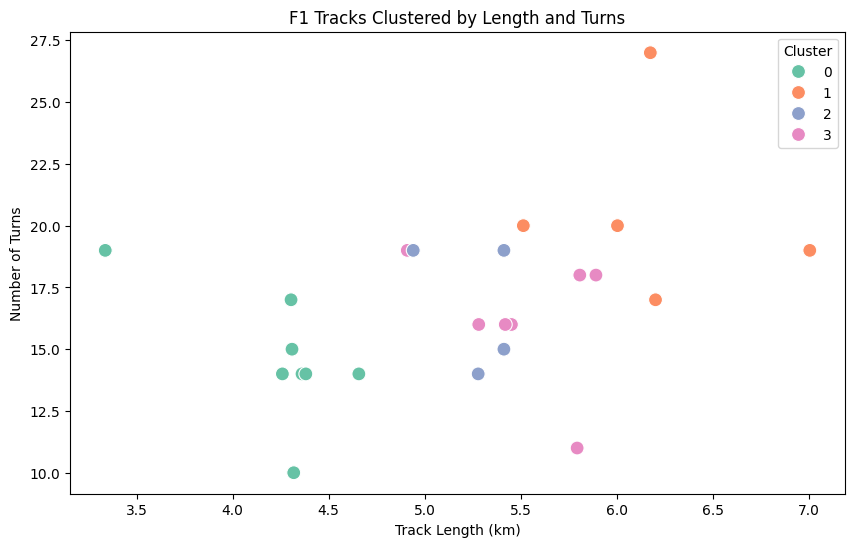


Cluster 0 examples:
                     Circuit Name       City Country  Circuit Length(km)  \
7               Circuit de Monaco     Monaco  Monaco               3.337   
8       Circuit Gilles-Villeneuve   Montréal  Canada               4.361   
9  Circuit de Barcelona-Catalunya  Barcelona   Spain               4.657   

   Turns  DRS Zones  
7     19          1  
8     14          3  
9     14          2  

Cluster 1 examples:
                    Circuit Name               City       Country  \
1        Jeddah Corniche Circuit             Jeddah  Saudi Arabia   
13  Circuit de Spa-Francorchamps  Spa-Francorchamps       Belgium   
16             Baku City Circuit               Baku    Azerbaijan   

    Circuit Length(km)  Turns  DRS Zones  
1                6.174     27          3  
13               7.004     19          2  
16               6.003     20          2  

Cluster 2 examples:
                     Circuit Name       City        Country  \
0   Bahrain International Circui

In [72]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method to find optimal k
# inertia = []
# K_range = range(1, 10)
# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_scaled)
#     inertia.append(kmeans.inertia_)

# plt.figure(figsize=(8, 5))
# plt.plot(K_range, inertia, 'bo-')
# plt.xlabel('Number of clusters k')
# plt.ylabel('Inertia (Distortion)')
# plt.title('Elbow Method for Optimal k')
# plt.grid(True)
# #plt.show()

k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42)
tracks['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tracks, x='Circuit Length(km)', y='Turns',
    hue='cluster', palette='Set2', s=100
)
plt.title('F1 Tracks Clustered by Length and Turns')
plt.xlabel('Track Length (km)')
plt.ylabel('Number of Turns')
plt.legend(title='Cluster')
plt.show()


for c in range(k_final):
    print(f"\nCluster {c} examples:")
    print(tracks[tracks['cluster'] == c][['Circuit Name', 'City', 'Country', 'Circuit Length(km)', 'Turns', 'DRS Zones']].head(3))


In [73]:
df = pd.concat(all_results)
df

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps,RoundNumber,Country,EventName,Season,MinQualiTime,QualiPosition,SpeedFL,TrackStatus,LapEndTime,Quali_AirTemp,Quali_Humidity,Quali_Pressure,Quali_Rainfall,Quali_TrackTemp,Quali_WindDirection,Quali_WindSpeed,FP3BestLapTime,FP3_AirTemp,FP3_TrackTemp,FP3_Humidity,FP3_Pressure,FP3_Rainfall,FP3_WindDirection,FP3_WindSpeed,FP2BestLapTime,FP2_AirTemp,FP2_TrackTemp,FP2_Humidity,FP2_Pressure,FP2_Rainfall,FP2_WindDirection,FP2_WindSpeed
0,77,V BOTTAS,BOT,bottas,Mercedes,00d2be,mercedes,Valtteri,Bottas,Valtteri Bottas,,,1.0,1,2.0,NaT,NaT,NaT,0 days 01:25:27.325000,Finished,26.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:20.598000,2.0,296.0,1,0 days 01:08:40.635000,23.1,69.8,1016.8,False,35.6,0.0,1.3,0 days 00:01:23.422000,23.5,46.1,59.0,1017.9,False,342.0,0.5,0 days 00:01:22.648000,22.0,41.7,55.9,1017.5,False,107.0,1.3
1,44,L HAMILTON,HAM,hamilton,Mercedes,00d2be,mercedes,Lewis,Hamilton,Lewis Hamilton,,,2.0,2,1.0,NaT,NaT,NaT,0 days 00:00:20.886000,Finished,18.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:20.486000,1.0,303.0,1,0 days 01:16:22.363000,22.9,69.2,1016.8,False,34.3,161.0,2.9,0 days 00:01:22.292000,23.3,45.8,59.5,1017.9,False,339.0,0.8,0 days 00:01:22.600000,21.8,41.7,56.0,1017.6,False,149.0,1.8
2,33,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,1e41ff,red_bull,Max,Verstappen,Max Verstappen,,,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:22.520000,Finished,15.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:21.320000,4.0,301.0,1,0 days 01:17:38.851000,22.8,69.4,1016.8,False,34.3,158.0,1.4,0 days 00:01:23.481000,23.4,45.2,59.7,1017.8,False,190.0,1.0,0 days 00:01:23.400000,21.8,38.8,56.6,1017.7,False,170.0,1.6
3,5,S VETTEL,VET,vettel,Ferrari,dc0000,ferrari,Sebastian,Vettel,Sebastian Vettel,,,4.0,4,3.0,NaT,NaT,NaT,0 days 00:00:57.109000,Finished,12.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:21.190000,3.0,303.0,1,0 days 01:16:57.375000,22.9,69.2,1016.8,False,34.3,161.0,2.9,0 days 00:01:22.556000,23.3,45.6,58.6,1017.9,False,190.0,0.8,0 days 00:01:23.473000,21.9,42.4,57.2,1017.5,False,167.0,1.0
4,16,C LECLERC,LEC,leclerc,Ferrari,dc0000,ferrari,Charles,Leclerc,Charles Leclerc,,,5.0,5,5.0,NaT,NaT,NaT,0 days 00:00:58.203000,Finished,10.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:21.442000,5.0,304.0,1,0 days 01:09:03.401000,23.1,69.1,1016.7,False,35.5,172.0,0.7,0 days 00:01:22.749000,23.3,45.8,59.5,1017.9,False,339.0,0.8,0 days 00:01:23.754000,21.9,42.7,56.1,1017.5,False,190.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,20,K MAGNUSSEN,MAG,kevin_magnussen,Haas F1 Team,B6BABD,haas,Kevin,Magnussen,Kevin Magnussen,https://media.formula1.com/d_driver_fallback_i...,DEN,16.0,16,14.0,NaT,NaT,NaT,0 days 00:01:17.597000,Lapped,0.0,57.0,24,United Arab Emirates,Abu Dhabi Grand Prix,2024,0 days 00:01:23.632000,15.0,221.0,1,0 days 00:25:22.784000,26.0,64.0,1017.2,False,30.1,274.0,1.7,0 days 00:01:24.094000,27.8,39.4,61.0,1016.7,False,268.0,2.1,0 days 00:01:24.235000,26.3,31.3,67.0,1016.6,False,278.0,1.1
16,30,L LAWSON,LAW,lawson,RB,6692FF,rb,Liam,Lawson,Liam Lawson,None,NZL,17.0,17,12.0,NaT,NaT,NaT,NaT,Finished,0.0,55.0,24,United Arab Emirates,Abu Dhabi Grand Prix,2024,0 days 00:01:23.472000,12.0,220.0,1,0 days 01:00:25.379000,25.6,69.0,1017.4,False,29.3,282.0,1.4,0 days 00:01:24.519000,27.8,39.2,60.0,1016.6,False,290.0,2.4,0 days 00:01:24.503000,26.3,31.5,67.0,1016.7,False,314.0,1.3
17,77,V BOTTAS,BOT,bottas,Kick Sauber,52e252,sauber,Valtteri,Bottas,Valtteri Bottas,https://media.formula1.com/d_driver_fallback_i...,FIN,18.0,R,9.0,NaT,NaT,NaT,NaT,Retired,0.0,30.0,24,United Arab Emirates,Abu Dhabi Grand Prix,2024,0 day

# Visualising data
I print out the table in order to make sure the length of the table looks accurate to help troubleshoot

In [74]:
tracks = tracks.drop(columns= ['GP Name', 'City', 'Circuit Name', 'First GP', 'Record Owner', 'Record Year', 'Race Date', 'Country'])

df = df.merge(tracks, on='RoundNumber')

In [75]:
df

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps,RoundNumber,Country,EventName,Season,MinQualiTime,QualiPosition,SpeedFL,TrackStatus,LapEndTime,Quali_AirTemp,Quali_Humidity,Quali_Pressure,Quali_Rainfall,Quali_TrackTemp,Quali_WindDirection,Quali_WindSpeed,FP3BestLapTime,FP3_AirTemp,FP3_TrackTemp,FP3_Humidity,FP3_Pressure,FP3_Rainfall,FP3_WindDirection,FP3_WindSpeed,FP2BestLapTime,FP2_AirTemp,FP2_TrackTemp,FP2_Humidity,FP2_Pressure,FP2_Rainfall,FP2_WindDirection,FP2_WindSpeed,Number of Laps,Circuit Length(km),Race Distance(km),Lap Record,Turns,DRS Zones,cluster
0,77,V BOTTAS,BOT,bottas,Mercedes,00d2be,mercedes,Valtteri,Bottas,Valtteri Bottas,,,1.0,1,2.0,NaT,NaT,NaT,0 days 01:25:27.325000,Finished,26.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:20.598000,2.0,296.0,1,0 days 01:08:40.635000,23.1,69.8,1016.8,False,35.6,0.0,1.3,0 days 00:01:23.422000,23.5,46.1,59.0,1017.9,False,342.0,0.5,0 days 00:01:22.648000,22.0,41.7,55.9,1017.5,False,107.0,1.3,57,5.412,308.238,91.447,15,3,2
1,44,L HAMILTON,HAM,hamilton,Mercedes,00d2be,mercedes,Lewis,Hamilton,Lewis Hamilton,,,2.0,2,1.0,NaT,NaT,NaT,0 days 00:00:20.886000,Finished,18.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:20.486000,1.0,303.0,1,0 days 01:16:22.363000,22.9,69.2,1016.8,False,34.3,161.0,2.9,0 days 00:01:22.292000,23.3,45.8,59.5,1017.9,False,339.0,0.8,0 days 00:01:22.600000,21.8,41.7,56.0,1017.6,False,149.0,1.8,57,5.412,308.238,91.447,15,3,2
2,33,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,1e41ff,red_bull,Max,Verstappen,Max Verstappen,,,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:22.520000,Finished,15.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:21.320000,4.0,301.0,1,0 days 01:17:38.851000,22.8,69.4,1016.8,False,34.3,158.0,1.4,0 days 00:01:23.481000,23.4,45.2,59.7,1017.8,False,190.0,1.0,0 days 00:01:23.400000,21.8,38.8,56.6,1017.7,False,170.0,1.6,57,5.412,308.238,91.447,15,3,2
3,5,S VETTEL,VET,vettel,Ferrari,dc0000,ferrari,Sebastian,Vettel,Sebastian Vettel,,,4.0,4,3.0,NaT,NaT,NaT,0 days 00:00:57.109000,Finished,12.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:21.190000,3.0,303.0,1,0 days 01:16:57.375000,22.9,69.2,1016.8,False,34.3,161.0,2.9,0 days 00:01:22.556000,23.3,45.6,58.6,1017.9,False,190.0,0.8,0 days 00:01:23.473000,21.9,42.4,57.2,1017.5,False,167.0,1.0,57,5.412,308.238,91.447,15,3,2
4,16,C LECLERC,LEC,leclerc,Ferrari,dc0000,ferrari,Charles,Leclerc,Charles Leclerc,,,5.0,5,5.0,NaT,NaT,NaT,0 days 00:00:58.203000,Finished,10.0,58.0,1,Australia,Australian Grand Prix,2019,0 days 00:01:21.442000,5.0,304.0,1,0 days 01:09:03.401000,23.1,69.1,1016.7,False,35.5,172.0,0.7,0 days 00:01:22.749000,23.3,45.8,59.5,1017.9,False,339.0,0.8,0 days 00:01:23.754000,21.9,42.7,56.1,1017.5,False,190.0,2.5,57,5.412,308.238,91.447,15,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,20,K MAGNUSSEN,MAG,kevin_magnussen,Haas F1 Team,B6BABD,haas,Kevin,Magnussen,Kevin Magnussen,https://media.formula1.com/d_driver_fallback_i...,DEN,16.0,16,14.0,NaT,NaT,NaT,0 days 00:01:17.597000,Lapped,0.0,57.0,24,United Arab Emirates,Abu Dhabi Grand Prix,2024,0 days 00:01:23.632000,15.0,221.0,1,0 days 00:25:22.784000,26.0,64.0,1017.2,False,30.1,274.0,1.7,0 days 00:01:24.094000,27.8,39.4,61.0,1016.7,False,268.0,2.1,0 days 00:01:24.235000,26.3,31.3,67.0,1016.6,False,278.0,1.1,58,5.281,306.183,85.637,16,2,3
2015,30,L LAWSON,LAW,lawson,RB,6692FF,rb,Liam,Lawson,Liam Lawson,None,NZL,17.0,17,12.0,NaT,NaT,NaT,NaT,Finished,0.0,55.0,24,United Arab Emirates,Abu Dhabi Grand Prix,2024,0 days 00:01:23.472000,12.0,220.0,1,0 days 01:00:25.379000,25.6,69.0,1017.4,False,29.3,282.0,1.4,0 days 00:01:24.519000,27.8,39.2,60.0,1016.6,False,290

In [76]:
df.to_parquet('raw_season_data.parquet')

In [ ]:
df[(df['Season'] == 2020) & df['RoundNumber']== 9]

# Build features

### Add FP3 delta feature

In [ ]:
# Compute fastest FP3 time per 

In [ ]:
# Compute fastest FP3 time per race
best_fp3_times = df.groupby(["EventName", "RoundNumber"])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"}).reset_index()
df = pd.merge(df, best_fp3_times, how="left", on=["EventName", "RoundNumber"])

In [ ]:
df["FP3Delta"] = df["FP3BestLapTime"] - df["FP3BestOverallLapTime"]
df["FP3DeltaFrac"] = df["FP3Delta"] / df["FP3BestLapTime"]

# Really simple model

### FP3 delta time as a predictor of race position

In [ ]:
df.head(10)

In [ ]:
X = df[["FP3DeltaFrac"]]
y = df["Position"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Import LinearRegression.
from sklearn.linear_model import LinearRegression


# Instantiate linear regression model.
model = LinearRegression()

In [ ]:
# Fit the model to the training data.
model.fit(X_train, y_train)

In [ ]:
import seaborn as sns

In [ ]:
# In-sample results
y_pred = model.predict(X_train)
sns.scatterplot(pd.DataFrame.from_dict({"y": y_train, "y_pred": y_pred}), x="y", y="y_pred")

In [ ]:
# Test results
y_pred = model.predict(X_test)
sns.scatterplot(pd.DataFrame.from_dict({"y": y_test, "y_pred": y_pred}), x="y", y="y_pred")